# Package Imports #

In [26]:
# Import the necessary packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as mpgs
import glob
%matplotlib inline

# Helper Functions #

In [27]:
# Helper function to merge two lists of images, alternating between both lists
# This is required to display images for comparison

def merge_lists(imgarray1, imgarray2, count=None):
    
    if count is None:
        count = len(imgarray1)
    output = []
    for i in range(count):
        output.append(imgarray1[i])
        output.append(imgarray2[i])
    
    return output

In [28]:
# Helper function to display images
# The input array should contain an even number of images

def display_images(imgarray, titles=None, cmap=None):
    ncols = 2
    nrows = int(len(imgarray)/2)
    figsize = (ncols*9, nrows*7)
        
    fig = plt.figure(figsize=figsize)
    gs = mpgs.GridSpec(nrows, ncols)
    gs.update(bottom=0.375)
    for i in range(len(imgarray)):
        sub = plt.subplot(gs[i])
        if titles is not None:
            sub.set_title(titles[i], size=17)
        sub.imshow(imgarray[i], cmap=cmap)


In [29]:
# Helper function to calibrate the camera

def calibrate_camera(chess_images):
       
    objpoints = []
    imgpoints = []
    
    # Initialize grid points to feed to objpoints
    objpoints_base = np.zeros((rows*cols, 3), np.float32)
    objpoints_base[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

    for img in chess_images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows))
        
        if(ret):
            # Append points and actual co-ordinates
            objpoints.append(objpoints_base)
            imgpoints.append(corners)
    
    print("\nCalibrating the camera using {} of {} chessboard images".format(len(imgpoints), len(chess_images)))
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
       
    # Return the camera matrix and distortion coefficients
    return mtx, dist

In [30]:
# Helper function to undistort images

def undistort_images(dist_images, mtx, dist, multi=False):
    
    # For a single image
    if not multi:
        return cv2.undistort(dist_images, mtx, dist)
        
    # Use cv2 to undistort each image
    undistorted_images = np.array([cv2.undistort(img, mtx, dist) for img in dist_images])
    
    return undistorted_images

In [32]:
# Helper function to warp images with a perspective transform

def warp_images(src_images, M, multi=False):
    
    # For a single image
    if not multi:
        return cv2.warpPerspective(src_images, M, src_images.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    # Calculate the image shape
    shape = src_images[0].shape[1::-1]
    
    # Use cv2 to apply the perspective transform on each image
    warped_images = np.array([cv2.warpPerspective(img, M, shape,
                                                  flags=cv2.INTER_LINEAR) for img in src_images])
    
    return warped_images 

In [33]:
# Helper function to apply a region of interest mask

def region_mask(img):
    
    # Create an all-zero mask
    mask = np.zeros_like(img)
    out_mask_color = 1
    mask = mask.astype(np.float32)
    
    # Define polygon co-ordinates
    bottom_left = [200, 668]
    top_left = [565, 420]
    mid_left = [565, 638]
    mid_right = [735, 638]
    top_right = [735, 420]
    bottom_right = [1150, 668]
    vertices = np.array([[bottom_left, top_left, mid_left, mid_right, top_right, bottom_right]], dtype=np.int32)
    

    # Fill poly and apply to the mask
    cv2.fillPoly(mask, vertices, out_mask_color)
    
    # Retain only the ROI on the original image
    mask = mask.astype(np.uint8)
    img = img.astype(np.uint8)
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    
    return masked_image

In [34]:
# Helper function to apply color thresholding

def color_filters(img, s_thresholds=(100,255)):
    
    # Convert to HLS space and isolate the S channel
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    
    # Prepare a binary output based on thresholds
    binary_img = np.zeros_like(s_channel)
    binary_img[(s_channel > s_thresholds[0]) & (s_channel <= s_thresholds[1])] = 1
    
    return binary_img

In [35]:
# Helper function that takes a grayscale image and applies gradient thresholds

def gradient_filters(img, sobel_kernel=5, mag_thresholds=(100,200), 
                     x_thresholds=(25,255), 
                                dir_thresholds=(np.pi*45/180, np.pi*80/180)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradients along x and y axes
    x_grad = np.abs(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    y_grad = np.abs(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    abs_x_grad = np.abs(x_grad)
    abs_y_grad = np.abs(y_grad)
    
    scaled_img_x = np.uint(255*abs_x_grad/np.max(abs_x_grad))
    scaled_img_y = np.uint(255*abs_y_grad/np.max(abs_y_grad))
    
    # Calculate the magnitude of the gradients
    mag_grad = np.sqrt(x_grad**2 + y_grad**2)
    mag_grad = np.uint8(255 * mag_grad / np.max(mag_grad))
    
    # Caculdate gradient angle
    dir_angle = np.arctan2(y_grad, x_grad)
    # Combine thresholds
    binary_output = np.zeros_like(scaled_img_x)
    binary_output[\
                #(mag_grad > mag_thresholds[0]) & (mag_grad <= mag_thresholds[1]) &\
                 (scaled_img_x > x_thresholds[0]) & (scaled_img_x <= x_thresholds[1]) &\
                  (dir_angle > dir_thresholds[0]) & (dir_angle <= dir_thresholds[1])\
                 ] = 1
    
    return binary_output

In [36]:
# class to keep track of Lane line information

from collections import deque

class Lane():
    
    def __init__(self, retain, max_undetected):
      
        self.retain = retain
        self.detected = False
        self.undetected_count = 0
        self.max_undetected = max_undetected
        
        self.last_n_x = deque(maxlen=retain)
        self.last_n_y = deque(maxlen=retain)
        
        self.last_n_polyfit = deque(maxlen=retain)
        
        self.current_curvature = None
        
        self.last_n_hdist = deque(maxlen=retain)
        self.current_hdist = None
    
    def add_polyfit(self, fit):
        self.last_n_polyfit.append(fit)
        
    def get_mean_polyfit(self):
        
        return np.mean(self.last_n_polyfit, 0)
    
    def clear_undetected_count(self):
        self.undetected_count = 0
    
    def update_undetected_count(self):
        self.undetected_count += 1
        return self.undetected_count
    
    def is_reset_required(self):
        return self.undetected_count >= self.max_undetected

# Initial Processing #
Code which uses the helper functions to calibrate the camera. Also demos undistortion.

In [37]:
# Read in all the test images

filenames = glob.glob( "test_images\*.jpg")
test_images = np.array([mpimg.imread(name) for name in filenames])

In [17]:
# Display the first four test images
#display_images(test_images, titles=[x.split("\\")[-1] for x in filenames])

### Camera Calibration ###

In [38]:
# Read the chessboard images
chess_filenames = glob.glob("camera_cal\calibration*.jpg")
chess_images =  np.array([mpimg.imread(name) for name in chess_filenames])
rows, cols = 6, 9

# Call the helper function to calibrate the camera
mtx, dist = calibrate_camera(chess_images)


Calibrating the camera using 17 of 20 chessboard images


In [19]:
# Call the helper function to undistort the test images
#undist_images = undistort_images(chess_images, mtx, dist, multi=True)

# Display 5 chess board images and their undistorted versions
#display_images(merge_lists(chess_images, undist_images, 5 ),titles=["Original", "Undistorted"]*5)

### Perspective Transform ###

In [39]:
# Pick an image for defining the perspective transform
source_img = test_images[0]

# Define the source and destination points for the perspective transform
srcTL = [584, 458]
srcTR = [701, 458]
srcBR = [1030, 668]
srcBL = [283, 668]

src = np.float32([srcTL, srcTR, srcBR, srcBL])
dst = np.float32([[375, 0], [900, 0], [900, 720], [375, 720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped_img = warp_images(source_img, M)

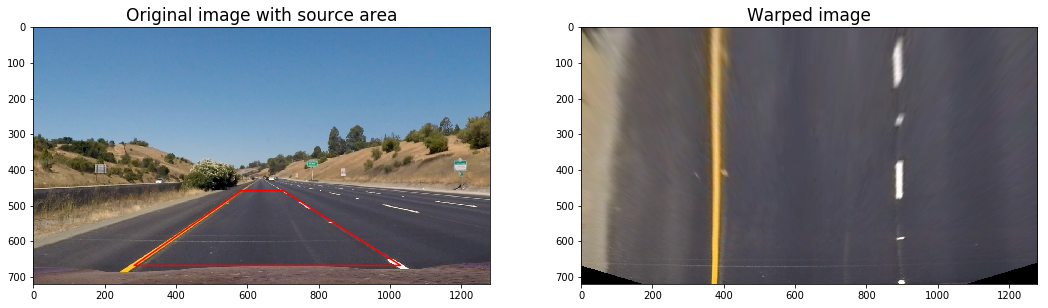

In [21]:
# Compare the original and warped image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,32))
ax1.imshow(source_img)
ax1.plot([srcTL[0], srcTR[0], srcBR[0], srcBL[0], srcTL[0]],
         [srcTL[1], srcTR[1], srcBR[1], srcBL[1], srcTL[1]], color='red')
ax1.set_title("Original image with source area", size=17)
ax2.imshow(warped_img)
ax2.set_title("Warped image", size=17)

In [22]:
# Warp all test images and display them using the helper functions
#display_images(warp_images(test_images, M, multi=True))

### Region of Interest ###

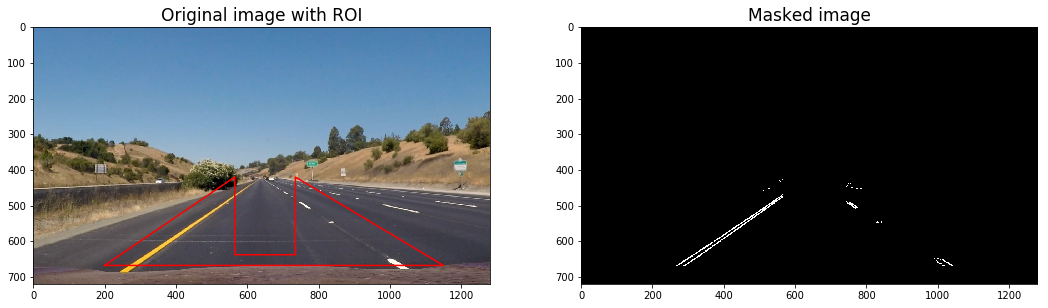

In [40]:
# For clarity, display the ROI on the original image

bottom_left = [200, 668]
top_left = [565, 420]
mid_left = [565, 638]
mid_right = [735, 638]
top_right = [735, 420]
bottom_right = [1150, 668]
vertices = np.array([[bottom_left, top_left, mid_left, mid_right, top_right, bottom_right]], dtype=np.int32)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,32))
ax1.imshow(test_images[0])
ax1.plot([bottom_left[0], top_left[0], mid_left[0], mid_right[0], top_right[0], bottom_right[0], bottom_left[0]],
        [bottom_left[1], top_left[1], mid_left[1], mid_right[1], top_right[1], bottom_right[1], bottom_left[1]], color='red')
ax1.set_title("Original image with ROI", size=17)
ax2.imshow(region_mask(gradient_filters(test_images[0])), cmap='gray')
ax2.set_title("Masked image", size=17)




In [24]:
# Display the ROI mask on all test images using the helper function

#roi_images = [region_mask(img) for img in test_images]
#display_images(merge_lists(test_images, roi_images),
               titles = ["Original", "Masked"]*len(test_images))

IndentationError: unexpected indent (<ipython-input-24-74e4b70f1191>, line 5)

### Color Thresholding ###

In [ ]:
# Apply color thresholding on all test images

#s_images = np.array([color_filters(img, s_thresholds=(80,255)) for img in test_images])

#display_images(merge_lists(test_images, s_images), cmap='gray')

### Gradient Thresholding ###

In [ ]:
#grad_images = np.array([gradient_filters(img, sobel_kernel=5,
                                         mag_thresholds=(1,255),
                                        x_thresholds=(25,255),
                                        dir_thresholds=(np.pi*45/180, np.pi*80/180)
                                        ) for img in test_images])

#display_images(merge_lists(test_images, grad_images), titles=["Original", "Thresholded"]*len(test_images), cmap='gray')

# Pipeline #

In [41]:
# Method to find lane lines from scratch

def reset_lane_lines(binary_img, visualize=False):
    
    # Find the x base points
    histogram = np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)
    mid = int(len(histogram)/2)
    left_base = np.argmax(histogram[:mid])
    right_base = np.argmax(histogram[mid:])+mid
    
    # Process for visualization
    if visualize:
        disp_img_arr = []
        disp_img_titles= []
        
        # 3 channels, black background, detected pixels in white
        disp_img = np.dstack((binary_img, binary_img, binary_img))*255
        disp_img_arr.append(disp_img)
        disp_img_titles.append("Warped image")
        img = np.copy(disp_img)
        
    # Define the sliding window size
    win_h = 70
     
    # minimum pixels required to re-center
    min_px = 40 
    margin = 100
    
    # window boundaries in y
    y_low = binary_img.shape[0]
    y_top = y_low - win_h
    
    # non-zero pixels
    nonz = binary_img.nonzero()
    nonz_y = np.array(nonz[0])
    nonz_x = np.array(nonz[1])

    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    for window in range(binary_img.shape[0]//win_h):

        # Determine the current window borders
        left_x_l = int(left_base - margin/2)
        left_x_r = int(left_base + margin/2)
        
        right_x_l = int(right_base - margin/2)
        right_x_r = int(right_base + margin/2)
        
        if visualize: 
            cv2.rectangle(img,(right_x_l, y_low),(right_x_r, y_top),(0,0,255),3)
            cv2.rectangle(img,(left_x_l, y_low),(left_x_r, y_top),(0,255,0),3)
        
        # Determine non-zero pixels within the window
        left_idx = ((nonz_y >= y_top) & (nonz_y <= y_low) & (nonz_x >= left_x_l) & (nonz_x <= left_x_r)).nonzero()[0]
        right_idx = ((nonz_y >= y_top) & (nonz_y <= y_low) & (nonz_x >= right_x_l) & (nonz_x <= right_x_r)).nonzero()[0]
        
        left_x = np.concatenate((left_x, nonz_x[left_idx]))
        left_y = np.concatenate((left_y, nonz_y[left_idx]))
        right_x = np.concatenate((right_x, nonz_x[right_idx]))
        right_y = np.concatenate((right_y, nonz_y[right_idx]))
        
        # Update the window position along y
        y_low = y_low-win_h
        y_top = y_top-win_h
        
        # If enough pixels were found in the current window, update the window's center along x
        if(np.count_nonzero(left_idx) >= min_px):
            left_base = int(np.mean(nonz_x[left_idx]))
        if(np.count_nonzero(right_idx) >= min_px):
            right_base = int(np.mean(nonz_x[right_idx]))
    
    # Return if not enough pixels were detected
    if(len(left_x)==0 or len(right_x)==0):
        return False, None, None
        
    # Fit pixels to a line    
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    if visualize:
        y_points = np.linspace(0, binary_img.shape[0], binary_img.shape[0], endpoint=False)
        x_points_left = left_fit[0]*y_points**2 + left_fit[1]*y_points + left_fit[2]
        x_points_right = right_fit[0]*y_points**2 + right_fit[1]*y_points + right_fit[2]
        
        cv2.polylines(img, np.array([list(zip(x_points_left, y_points))], dtype=np.int32),
                      isClosed=False, color=((255,0,0)),lineType=4, thickness=3)
        cv2.polylines(img, np.array([list(zip(x_points_right, y_points))], dtype=np.int32),
                      isClosed=False, color=((255,0,0)),lineType=4, thickness=3)
        
        disp_img_arr.append(img)
        disp_img_titles.append("Sliding Windows")
    
    if visualize:
        return disp_img_arr, disp_img_titles, left_fit, right_fit
    else:
        return True, left_fit, right_fit

In [42]:
# Method to find lane lines given previous polyfits

def continue_lane_lines(binary_img, left_fit, right_fit):
    
    nonz = binary_img.nonzero()
    nonz_y = np.array(nonz[0])
    nonz_x = np.array(nonz[1])
    
    margin = 75
    
    left_idx = (nonz_x > (left_fit[0]*(nonz_y**2) + left_fit[1]*nonz_y + left_fit[2] - margin)) &\
    (nonz_x < (left_fit[0]*(nonz_y**2) + left_fit[1]*nonz_y + left_fit[2] + margin))
    right_idx = (nonz_x > (right_fit[0]*(nonz_y**2) + right_fit[1]*nonz_y + right_fit[2] - margin)) &\
    (nonz_x < (right_fit[0]*(nonz_y**2) + right_fit[1]*nonz_y + right_fit[2] + margin))

    # If no pixels were found for the current lane line polyfits, return
    if(np.count_nonzero(left_idx)==0 or np.count_nonzero(right_idx)==0):
        return False, None, None
    
    # Else, calculate and return the new polyfits
    else:   
        left_x = nonz_x[left_idx]
        left_y = nonz_y[left_idx]
        right_x = nonz_x[right_idx]
        right_y = nonz_y[right_idx]
    
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
        
        return True, left_fit, right_fit

In [52]:
# Method that deals with operations related to the lane lines
# Returns the polyfit for both lanes

def get_lane_lines(binary_img):
    
    global left_lane, right_lane, first_run
    # Find lane lines
    if(first_run):
        
        first_run = False
        # Reset lane lines since it's the first run
        ret, left_fit, right_fit = reset_lane_lines(binary_img)
        
        # create new Lane objects to track both lanes
        left_lane = Lane(retain=20, max_undetected=20)
        right_lane = Lane(retain=20, max_undetected=20)
        
        left_lane.add_polyfit(left_fit)
        right_lane.add_polyfit(right_fit)
        
        return left_fit, right_fit
        
    else:
        # Get the mean polyfits from the previous frames
        left_fit = left_lane.get_mean_polyfit()
        right_fit = right_lane.get_mean_polyfit()
        
        # Find lane lines on the frame
        ret, left_fit, right_fit = continue_lane_lines(binary_img, left_fit, right_fit)
        if ret:
            # Update the lane lines based on the lines found on the current frame
            left_lane.add_polyfit(left_fit)
            left_lane.clear_undetected_count()
            
            right_lane.add_polyfit(right_fit)
            right_lane.clear_undetected_count()
            
            # Return the mean over the past frames
            
            return left_lane.get_mean_polyfit(), right_lane.get_mean_polyfit()
        
        else:
            # No lane lines were found on the current frame
            count_l = left_lane.update_undetected_count()
            count_r = right_lane.update_undetected_count()
            
            # If lanes were not detected for several frames, reset the polyfits
            if(left_lane.is_reset_required() or right_lane.is_reset_required()):
                ret, left_fit_new, right_fit_new = reset_lane_lines(warped_img)
                
                # If lanes were successfully detected, create new Lane objects and update them
                if ret:
                    left_lane = Lane(retain=20, max_undetected=20)
                    right_lane = Lane(retain=20, max_undetected=20)

                    left_lane.add_polyfit(left_fit)
                    right_lane.add_polyfit(right_fit)

                    return left_fit_new, right_fit_new
            

        # Lanes were not detected using both methods, use mean of the previous frames
        left_fit = left_lane.get_mean_polyfit()
        right_fit = right_lane.get_mean_polyfit()

        return left_fit, right_fit

In [44]:
# Pipeline to perform all necessary operations on invidivdual frames

def pipeline(image, visualize=False):
    
    # Undistort the image
    undist_img = undistort_images(image, mtx, dist)
    
    # Apply color thresholding
    color_thr_img = color_filters(undist_img, s_thresholds=(80,255))
    
    # Apply gradient thresholding
    grad_img = gradient_filters(undist_img, x_thresholds=(25,255), 
                                dir_thresholds=(np.pi*45/180, np.pi*80/180) )
    
    # Combined thresholds
    comb_img = np.zeros_like(grad_img)
    comb_img[(grad_img == 1) | (color_thr_img == 1)] = 1
    
    # Apply ROI
    roi_img = region_mask(comb_img)

    # Perspective transform
    warped_img = warp_images(roi_img, M)
           
    # Get polyfits
    left_fit, right_fit = get_lane_lines(warped_img)
    #ret, left_fit, right_fit = reset_lane_lines(warped_img)
    
    # Draw lane area
    warp_blank = np.zeros_like(warped_img).astype(np.uint8)
    color_blank = np.dstack((warp_blank, warp_blank, warp_blank))
    
    y_points = np.linspace(0, warped_img.shape[0], warped_img.shape[0], endpoint=False)
    x_points_left = left_fit[0]*y_points**2 + left_fit[1]*y_points + left_fit[2]
    x_points_right = right_fit[0]*y_points**2 + right_fit[1]*y_points + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([x_points_left, y_points]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([x_points_right, y_points])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_blank, np.int_([pts]), (0,255, 0))
    
    newwarp = cv2.warpPerspective(color_blank, Minv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    

    if visualize:
        return undist_img, color_thr_img, grad_img, comb_img, roi_img, warped_img
    else:
        return result


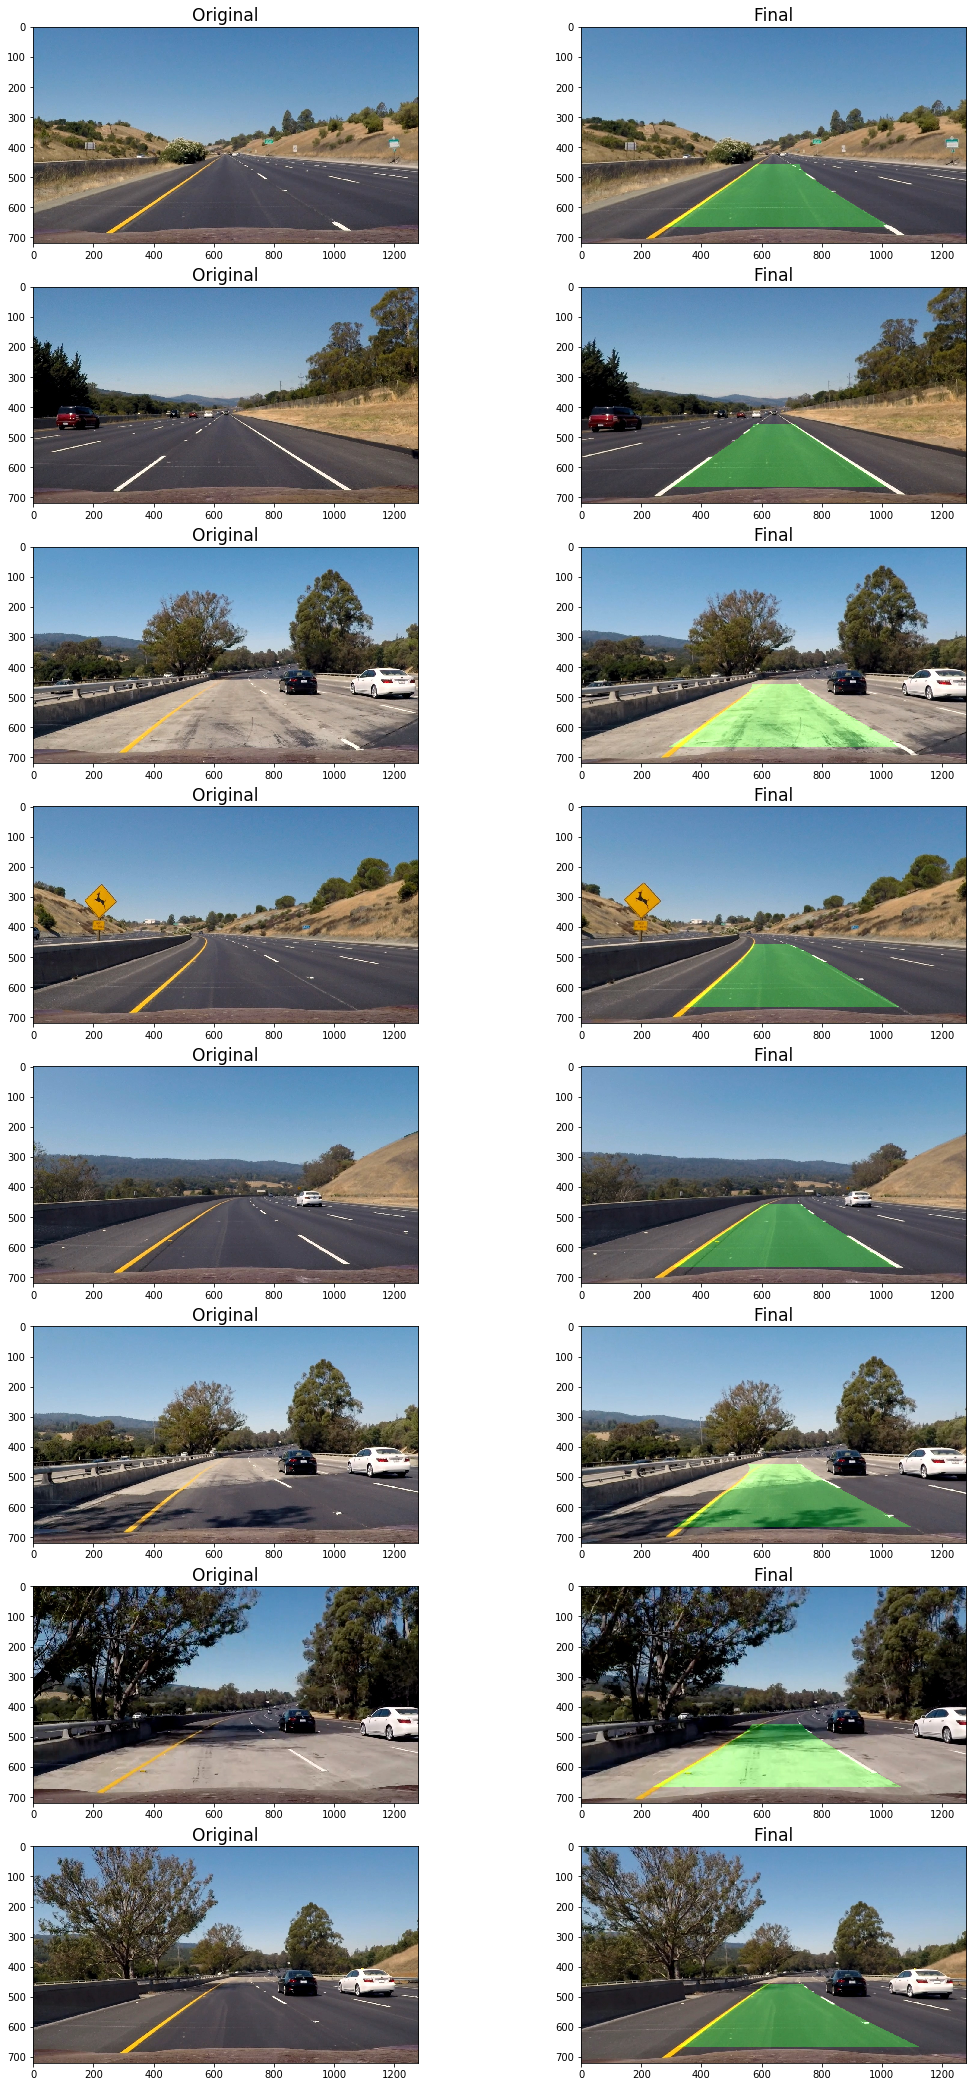

In [45]:
global left_lane, right_lane, first_run


final_images = []
for i in range(len(test_images)):
    left_lane=None
    right_lane=None
    first_run = True
    final_images.append(pipeline(test_images[i]))
    
display_images(merge_lists(test_images, final_images), titles=["Original", "Final"]*len(test_images))

In [ ]:
#a,b,c,d,e,f = pipeline(test_images[7], visualize=True)

#display_images([a,b,c,d,e,f], 
#titles=[ "Undistorted", "Color Threshold", "Gradient Threshold",
#                       "Combined Threshold", "Region of Interest", "Warped"],cmap='gray')

In [ ]:
# Find lane lines on a warped image and visualize it

warped, window_img, lf, rf = reset_lane_lines(f, visualize=True)

display_images(warped,window_img,cmap='gray')

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [ ]:
if not os.path.isdir("test_videos_output"):
    os.mkdir("test_videos_output")

In [54]:
v1_output = "test_videos_output/project_video_output.mp4"
project_video = VideoFileClip("project_video.mp4")
clip = project_video.fl_image(pipeline)
%time clip.write_videofile(v1_output, audio=False)

clip.reader.close()
clip.audio.reader.close_proc()

Found 12343 points for left and 3928 points for right
[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

Found 12677 points for left and 3928 points for right


  0%|                                                                                 | 1/1261 [00:00<06:36,  3.17it/s]

Found 13029 points for left and 4736 points for right


  0%|▏                                                                                | 2/1261 [00:00<06:22,  3.29it/s]

Found 13384 points for left and 5643 points for right


  0%|▏                                                                                | 3/1261 [00:00<06:19,  3.32it/s]

Found 13617 points for left and 6575 points for right


  0%|▎                                                                                | 4/1261 [00:01<06:11,  3.39it/s]

Found 14244 points for left and 6364 points for right


  0%|▎                                                                                | 5/1261 [00:01<06:21,  3.29it/s]

Found 14414 points for left and 5456 points for right


  0%|▍                                                                                | 6/1261 [00:01<06:10,  3.38it/s]

Found 14919 points for left and 4673 points for right


  1%|▍                                                                                | 7/1261 [00:02<06:21,  3.29it/s]

Found 15235 points for left and 4113 points for right


  1%|▌                                                                                | 8/1261 [00:02<06:01,  3.47it/s]

Found 15675 points for left and 3961 points for right


  1%|▌                                                                                | 9/1261 [00:02<05:46,  3.62it/s]

Found 16437 points for left and 3940 points for right


  1%|▋                                                                               | 10/1261 [00:02<05:33,  3.75it/s]

Found 16898 points for left and 3711 points for right


  1%|▋                                                                               | 11/1261 [00:03<05:27,  3.82it/s]

Found 17924 points for left and 3829 points for right


  1%|▊                                                                               | 12/1261 [00:03<05:21,  3.89it/s]

Found 18555 points for left and 3509 points for right


  1%|▊                                                                               | 13/1261 [00:03<05:18,  3.92it/s]

Found 19206 points for left and 3282 points for right


  1%|▉                                                                               | 14/1261 [00:03<05:14,  3.97it/s]

Found 19392 points for left and 3786 points for right


  1%|▉                                                                               | 15/1261 [00:04<05:12,  3.99it/s]

Found 18823 points for left and 4637 points for right


  1%|█                                                                               | 16/1261 [00:04<05:10,  4.01it/s]

Found 18525 points for left and 5038 points for right


  1%|█                                                                               | 17/1261 [00:04<05:12,  3.98it/s]

Found 18836 points for left and 5221 points for right


  1%|█▏                                                                              | 18/1261 [00:04<05:10,  4.00it/s]

Found 19307 points for left and 4740 points for right


  2%|█▏                                                                              | 19/1261 [00:05<05:08,  4.03it/s]

Found 19839 points for left and 4166 points for right


  2%|█▎                                                                              | 20/1261 [00:05<05:10,  3.99it/s]

Found 20495 points for left and 3990 points for right


  2%|█▎                                                                              | 21/1261 [00:05<05:11,  3.98it/s]

Found 21290 points for left and 3889 points for right


  2%|█▍                                                                              | 22/1261 [00:05<05:09,  4.01it/s]

Found 22000 points for left and 4067 points for right


  2%|█▍                                                                              | 23/1261 [00:06<05:07,  4.02it/s]

Found 21395 points for left and 3800 points for right


  2%|█▌                                                                              | 24/1261 [00:06<05:06,  4.03it/s]

Found 20879 points for left and 3437 points for right


  2%|█▌                                                                              | 25/1261 [00:06<05:06,  4.03it/s]

Found 21604 points for left and 3432 points for right


  2%|█▋                                                                              | 26/1261 [00:06<05:06,  4.03it/s]

Found 21784 points for left and 3448 points for right


  2%|█▋                                                                              | 27/1261 [00:07<05:05,  4.04it/s]

Found 22417 points for left and 4339 points for right


  2%|█▊                                                                              | 28/1261 [00:07<05:10,  3.97it/s]

Found 21870 points for left and 5373 points for right


  2%|█▊                                                                              | 29/1261 [00:07<05:15,  3.90it/s]

Found 21059 points for left and 5582 points for right


  2%|█▉                                                                              | 30/1261 [00:07<05:28,  3.75it/s]

Found 19858 points for left and 5400 points for right


  2%|█▉                                                                              | 31/1261 [00:08<05:31,  3.71it/s]

Found 19327 points for left and 4262 points for right


  3%|██                                                                              | 32/1261 [00:08<05:31,  3.70it/s]

Found 19863 points for left and 3837 points for right


  3%|██                                                                              | 33/1261 [00:08<05:33,  3.69it/s]

Found 19475 points for left and 3589 points for right


  3%|██▏                                                                             | 34/1261 [00:08<05:34,  3.67it/s]

Found 19587 points for left and 3532 points for right


  3%|██▏                                                                             | 35/1261 [00:09<05:34,  3.66it/s]

Found 19617 points for left and 3492 points for right


  3%|██▎                                                                             | 36/1261 [00:09<05:45,  3.55it/s]

Found 19311 points for left and 3385 points for right


  3%|██▎                                                                             | 37/1261 [00:09<05:43,  3.56it/s]

Found 19296 points for left and 3041 points for right


  3%|██▍                                                                             | 38/1261 [00:10<05:28,  3.73it/s]

Found 19381 points for left and 2860 points for right


  3%|██▍                                                                             | 39/1261 [00:10<05:16,  3.87it/s]

Found 19912 points for left and 2990 points for right


  3%|██▌                                                                             | 40/1261 [00:10<05:08,  3.96it/s]

Found 19883 points for left and 3858 points for right


  3%|██▌                                                                             | 41/1261 [00:10<05:01,  4.04it/s]

Found 20279 points for left and 4755 points for right


  3%|██▋                                                                             | 42/1261 [00:11<04:58,  4.08it/s]

Found 20719 points for left and 5119 points for right


  3%|██▋                                                                             | 43/1261 [00:11<05:06,  3.98it/s]

Found 21228 points for left and 4861 points for right


  3%|██▊                                                                             | 44/1261 [00:11<05:04,  3.99it/s]

Found 21382 points for left and 4252 points for right


  4%|██▊                                                                             | 45/1261 [00:11<05:02,  4.01it/s]

Found 21337 points for left and 3834 points for right


  4%|██▉                                                                             | 46/1261 [00:12<05:00,  4.04it/s]

Found 21785 points for left and 3712 points for right


  4%|██▉                                                                             | 47/1261 [00:12<04:58,  4.07it/s]

Found 21508 points for left and 3665 points for right


  4%|███                                                                             | 48/1261 [00:12<04:58,  4.07it/s]

Found 22266 points for left and 3683 points for right


  4%|███                                                                             | 49/1261 [00:12<05:00,  4.04it/s]

Found 22084 points for left and 3425 points for right


  4%|███▏                                                                            | 50/1261 [00:13<04:57,  4.07it/s]

Found 21530 points for left and 3183 points for right


  4%|███▏                                                                            | 51/1261 [00:13<04:59,  4.04it/s]

Found 22350 points for left and 2961 points for right


  4%|███▎                                                                            | 52/1261 [00:13<04:57,  4.06it/s]

Found 21574 points for left and 3253 points for right


  4%|███▎                                                                            | 53/1261 [00:13<05:00,  4.02it/s]

Found 21713 points for left and 4174 points for right


  4%|███▍                                                                            | 54/1261 [00:14<05:00,  4.01it/s]

Found 21876 points for left and 4650 points for right


  4%|███▍                                                                            | 55/1261 [00:14<05:01,  4.00it/s]

Found 21731 points for left and 4939 points for right


  4%|███▌                                                                            | 56/1261 [00:14<05:01,  4.00it/s]

Found 21969 points for left and 4543 points for right


  5%|███▌                                                                            | 57/1261 [00:14<05:08,  3.90it/s]

Found 22257 points for left and 3910 points for right


  5%|███▋                                                                            | 58/1261 [00:15<05:16,  3.81it/s]

Found 21510 points for left and 3698 points for right


  5%|███▋                                                                            | 59/1261 [00:15<05:17,  3.78it/s]

Found 20949 points for left and 3416 points for right


  5%|███▊                                                                            | 60/1261 [00:15<06:20,  3.16it/s]

Found 20372 points for left and 3294 points for right


  5%|███▊                                                                            | 61/1261 [00:16<06:21,  3.14it/s]

Found 19535 points for left and 3203 points for right


  5%|███▉                                                                            | 62/1261 [00:16<06:07,  3.27it/s]

Found 19781 points for left and 3090 points for right


  5%|███▉                                                                            | 63/1261 [00:16<06:34,  3.03it/s]

Found 19663 points for left and 2891 points for right


  5%|████                                                                            | 64/1261 [00:17<06:37,  3.01it/s]

Found 20393 points for left and 2713 points for right


  5%|████                                                                            | 65/1261 [00:17<06:13,  3.20it/s]

Found 19696 points for left and 3190 points for right


  5%|████▏                                                                           | 66/1261 [00:17<05:55,  3.36it/s]

Found 18961 points for left and 3780 points for right


  5%|████▎                                                                           | 67/1261 [00:17<05:42,  3.49it/s]

Found 19375 points for left and 4027 points for right


  5%|████▎                                                                           | 68/1261 [00:18<05:29,  3.62it/s]

Found 19313 points for left and 4093 points for right


  5%|████▍                                                                           | 69/1261 [00:18<05:17,  3.75it/s]

Found 20187 points for left and 3570 points for right


  6%|████▍                                                                           | 70/1261 [00:18<05:11,  3.82it/s]

Found 19998 points for left and 3337 points for right


  6%|████▌                                                                           | 71/1261 [00:18<05:06,  3.88it/s]

Found 20042 points for left and 3277 points for right


  6%|████▌                                                                           | 72/1261 [00:19<05:05,  3.89it/s]

Found 20976 points for left and 3288 points for right


  6%|████▋                                                                           | 73/1261 [00:19<05:05,  3.89it/s]

Found 20939 points for left and 3294 points for right


  6%|████▋                                                                           | 74/1261 [00:19<05:00,  3.95it/s]

Found 22066 points for left and 3126 points for right


  6%|████▊                                                                           | 75/1261 [00:19<04:56,  4.00it/s]

Found 21404 points for left and 2932 points for right


  6%|████▊                                                                           | 76/1261 [00:20<04:57,  3.98it/s]

Found 22305 points for left and 2891 points for right


  6%|████▉                                                                           | 77/1261 [00:20<04:58,  3.96it/s]

Found 22777 points for left and 2859 points for right


  6%|████▉                                                                           | 78/1261 [00:20<04:55,  4.01it/s]

Found 23028 points for left and 3579 points for right


  6%|█████                                                                           | 79/1261 [00:20<04:54,  4.02it/s]

Found 22450 points for left and 4042 points for right


  6%|█████                                                                           | 80/1261 [00:21<04:52,  4.03it/s]

Found 22080 points for left and 4355 points for right


  6%|█████▏                                                                          | 81/1261 [00:21<04:54,  4.01it/s]

Found 22473 points for left and 4383 points for right


  7%|█████▏                                                                          | 82/1261 [00:21<04:52,  4.02it/s]

Found 22558 points for left and 3914 points for right


  7%|█████▎                                                                          | 83/1261 [00:21<04:53,  4.02it/s]

Found 23350 points for left and 3899 points for right


  7%|█████▎                                                                          | 84/1261 [00:22<04:59,  3.93it/s]

Found 22849 points for left and 3727 points for right


  7%|█████▍                                                                          | 85/1261 [00:22<05:09,  3.80it/s]

Found 23065 points for left and 3653 points for right


  7%|█████▍                                                                          | 86/1261 [00:22<05:07,  3.82it/s]

Found 21339 points for left and 3404 points for right


  7%|█████▌                                                                          | 87/1261 [00:23<06:24,  3.05it/s]

Found 20139 points for left and 2994 points for right


  7%|█████▌                                                                          | 88/1261 [00:23<06:12,  3.15it/s]

Found 19739 points for left and 2874 points for right


  7%|█████▋                                                                          | 89/1261 [00:23<06:08,  3.18it/s]

Found 17731 points for left and 2668 points for right


  7%|█████▋                                                                          | 90/1261 [00:24<06:09,  3.17it/s]

Found 18258 points for left and 3017 points for right


  7%|█████▊                                                                          | 91/1261 [00:24<06:17,  3.10it/s]

Found 18468 points for left and 3711 points for right


  7%|█████▊                                                                          | 92/1261 [00:24<05:54,  3.29it/s]

Found 18085 points for left and 4105 points for right


  7%|█████▉                                                                          | 93/1261 [00:24<05:43,  3.40it/s]

Found 17798 points for left and 4287 points for right


  7%|█████▉                                                                          | 94/1261 [00:25<05:25,  3.59it/s]

Found 18251 points for left and 3828 points for right


  8%|██████                                                                          | 95/1261 [00:25<05:14,  3.70it/s]

Found 18176 points for left and 3435 points for right


  8%|██████                                                                          | 96/1261 [00:25<05:11,  3.74it/s]

Found 17846 points for left and 3303 points for right


  8%|██████▏                                                                         | 97/1261 [00:25<05:15,  3.69it/s]

Found 18374 points for left and 3283 points for right


  8%|██████▏                                                                         | 98/1261 [00:26<05:09,  3.76it/s]

Found 18413 points for left and 3331 points for right


  8%|██████▎                                                                         | 99/1261 [00:26<05:03,  3.83it/s]

Found 18351 points for left and 3124 points for right


  8%|██████▎                                                                        | 100/1261 [00:26<04:57,  3.90it/s]

Found 18179 points for left and 2993 points for right


  8%|██████▎                                                                        | 101/1261 [00:26<04:53,  3.95it/s]

Found 18391 points for left and 2846 points for right


  8%|██████▍                                                                        | 102/1261 [00:27<04:46,  4.04it/s]

Found 18286 points for left and 2936 points for right


  8%|██████▍                                                                        | 103/1261 [00:27<04:47,  4.02it/s]

Found 18453 points for left and 3727 points for right


  8%|██████▌                                                                        | 104/1261 [00:27<04:48,  4.01it/s]

Found 18986 points for left and 4379 points for right


  8%|██████▌                                                                        | 105/1261 [00:27<04:48,  4.00it/s]

Found 19132 points for left and 4760 points for right


  8%|██████▋                                                                        | 106/1261 [00:28<04:46,  4.03it/s]

Found 19220 points for left and 4682 points for right


  8%|██████▋                                                                        | 107/1261 [00:28<04:48,  4.00it/s]

Found 18990 points for left and 3954 points for right


  9%|██████▊                                                                        | 108/1261 [00:28<04:46,  4.02it/s]

Found 19076 points for left and 3857 points for right


  9%|██████▊                                                                        | 109/1261 [00:28<04:48,  4.00it/s]

Found 19216 points for left and 3765 points for right


  9%|██████▉                                                                        | 110/1261 [00:29<04:47,  4.00it/s]

Found 19047 points for left and 3615 points for right


  9%|██████▉                                                                        | 111/1261 [00:29<04:48,  3.99it/s]

Found 19386 points for left and 3733 points for right


  9%|███████                                                                        | 112/1261 [00:29<04:45,  4.03it/s]

Found 18568 points for left and 3213 points for right


  9%|███████                                                                        | 113/1261 [00:29<04:55,  3.88it/s]

Found 18314 points for left and 3061 points for right


  9%|███████▏                                                                       | 114/1261 [00:31<09:29,  2.01it/s]

Found 17783 points for left and 2935 points for right


  9%|███████▏                                                                       | 115/1261 [00:31<08:43,  2.19it/s]

Found 17393 points for left and 3493 points for right


  9%|███████▎                                                                       | 116/1261 [00:31<07:47,  2.45it/s]

Found 17582 points for left and 4397 points for right


  9%|███████▎                                                                       | 117/1261 [00:32<08:55,  2.14it/s]

Found 17736 points for left and 4700 points for right


  9%|███████▍                                                                       | 118/1261 [00:32<07:48,  2.44it/s]

Found 17913 points for left and 4714 points for right


  9%|███████▍                                                                       | 119/1261 [00:32<06:56,  2.74it/s]

Found 17179 points for left and 3993 points for right


 10%|███████▌                                                                       | 120/1261 [00:33<06:29,  2.93it/s]

Found 17240 points for left and 3643 points for right


 10%|███████▌                                                                       | 121/1261 [00:33<06:10,  3.07it/s]

Found 16890 points for left and 3420 points for right


 10%|███████▋                                                                       | 122/1261 [00:33<05:49,  3.26it/s]

Found 16968 points for left and 3282 points for right


 10%|███████▋                                                                       | 123/1261 [00:33<05:30,  3.44it/s]

Found 16959 points for left and 3266 points for right


 10%|███████▊                                                                       | 124/1261 [00:34<05:15,  3.61it/s]

Found 17303 points for left and 3189 points for right


 10%|███████▊                                                                       | 125/1261 [00:34<05:03,  3.74it/s]

Found 17825 points for left and 3021 points for right


 10%|███████▉                                                                       | 126/1261 [00:34<04:56,  3.82it/s]

Found 17862 points for left and 2852 points for right


 10%|███████▉                                                                       | 127/1261 [00:34<04:50,  3.90it/s]

Found 17996 points for left and 3161 points for right


 10%|████████                                                                       | 128/1261 [00:35<04:48,  3.93it/s]

Found 17462 points for left and 3941 points for right


 10%|████████                                                                       | 129/1261 [00:35<04:45,  3.97it/s]

Found 17162 points for left and 4773 points for right


 10%|████████▏                                                                      | 130/1261 [00:35<04:43,  3.98it/s]

Found 17023 points for left and 4891 points for right


 10%|████████▏                                                                      | 131/1261 [00:35<04:44,  3.98it/s]

Found 16631 points for left and 4431 points for right


 10%|████████▎                                                                      | 132/1261 [00:36<04:43,  3.99it/s]

Found 16613 points for left and 3776 points for right


 11%|████████▎                                                                      | 133/1261 [00:36<04:42,  3.99it/s]

Found 16531 points for left and 3420 points for right


 11%|████████▍                                                                      | 134/1261 [00:36<04:43,  3.98it/s]

Found 16847 points for left and 3375 points for right


 11%|████████▍                                                                      | 135/1261 [00:36<04:44,  3.96it/s]

Found 16573 points for left and 3562 points for right


 11%|████████▌                                                                      | 136/1261 [00:37<04:43,  3.97it/s]

Found 16732 points for left and 3375 points for right


 11%|████████▌                                                                      | 137/1261 [00:37<04:44,  3.95it/s]

Found 17376 points for left and 3208 points for right


 11%|████████▋                                                                      | 138/1261 [00:37<04:50,  3.87it/s]

Found 17556 points for left and 3183 points for right


 11%|████████▋                                                                      | 139/1261 [00:37<04:53,  3.82it/s]

Found 18216 points for left and 3171 points for right


 11%|████████▊                                                                      | 140/1261 [00:38<06:12,  3.01it/s]

Found 18008 points for left and 3766 points for right


 11%|████████▊                                                                      | 141/1261 [00:38<05:52,  3.18it/s]

Found 17702 points for left and 4764 points for right


 11%|████████▉                                                                      | 142/1261 [00:39<06:25,  2.90it/s]

Found 17292 points for left and 5072 points for right


 11%|████████▉                                                                      | 143/1261 [00:39<06:11,  3.01it/s]

Found 17588 points for left and 4971 points for right


 11%|█████████                                                                      | 144/1261 [00:39<05:54,  3.15it/s]

Found 17477 points for left and 4332 points for right


 11%|█████████                                                                      | 145/1261 [00:40<05:38,  3.30it/s]

Found 17165 points for left and 3596 points for right


 12%|█████████▏                                                                     | 146/1261 [00:40<05:22,  3.46it/s]

Found 17232 points for left and 3523 points for right


 12%|█████████▏                                                                     | 147/1261 [00:40<05:07,  3.62it/s]

Found 16124 points for left and 3344 points for right


 12%|█████████▎                                                                     | 148/1261 [00:40<05:00,  3.70it/s]

Found 16009 points for left and 3292 points for right


 12%|█████████▎                                                                     | 149/1261 [00:41<04:53,  3.79it/s]

Found 16843 points for left and 3206 points for right


 12%|█████████▍                                                                     | 150/1261 [00:41<04:47,  3.87it/s]

Found 16497 points for left and 3048 points for right


 12%|█████████▍                                                                     | 151/1261 [00:41<04:45,  3.89it/s]

Found 17134 points for left and 2968 points for right


 12%|█████████▌                                                                     | 152/1261 [00:41<04:41,  3.94it/s]

Found 17055 points for left and 3464 points for right


 12%|█████████▌                                                                     | 153/1261 [00:42<04:39,  3.96it/s]

Found 17817 points for left and 4552 points for right


 12%|█████████▋                                                                     | 154/1261 [00:42<04:37,  3.99it/s]

Found 18677 points for left and 5318 points for right


 12%|█████████▋                                                                     | 155/1261 [00:42<04:38,  3.98it/s]

Found 18701 points for left and 5396 points for right


 12%|█████████▊                                                                     | 156/1261 [00:42<04:35,  4.01it/s]

Found 19005 points for left and 4873 points for right


 12%|█████████▊                                                                     | 157/1261 [00:43<04:35,  4.00it/s]

Found 18874 points for left and 3897 points for right


 13%|█████████▉                                                                     | 158/1261 [00:43<04:33,  4.03it/s]

Found 19763 points for left and 3598 points for right


 13%|█████████▉                                                                     | 159/1261 [00:43<04:32,  4.05it/s]

Found 20123 points for left and 3443 points for right


 13%|██████████                                                                     | 160/1261 [00:43<04:33,  4.02it/s]

Found 20892 points for left and 3467 points for right


 13%|██████████                                                                     | 161/1261 [00:43<04:33,  4.02it/s]

Found 21357 points for left and 3419 points for right


 13%|██████████▏                                                                    | 162/1261 [00:44<04:34,  4.01it/s]

Found 21858 points for left and 3340 points for right


 13%|██████████▏                                                                    | 163/1261 [00:44<04:34,  4.00it/s]

Found 21231 points for left and 3066 points for right


 13%|██████████▎                                                                    | 164/1261 [00:44<04:41,  3.90it/s]

Found 20853 points for left and 2820 points for right


 13%|██████████▎                                                                    | 165/1261 [00:45<04:45,  3.83it/s]

Found 21181 points for left and 3303 points for right


 13%|██████████▍                                                                    | 166/1261 [00:45<04:53,  3.73it/s]

Found 20939 points for left and 4165 points for right


 13%|██████████▍                                                                    | 167/1261 [00:45<05:44,  3.18it/s]

Found 21584 points for left and 4549 points for right


 13%|██████████▌                                                                    | 168/1261 [00:46<05:57,  3.06it/s]

Found 22258 points for left and 4764 points for right


 13%|██████████▌                                                                    | 169/1261 [00:46<05:39,  3.22it/s]

Found 22620 points for left and 4403 points for right


 13%|██████████▋                                                                    | 170/1261 [00:46<05:50,  3.12it/s]

Found 22895 points for left and 3841 points for right


 14%|██████████▋                                                                    | 171/1261 [00:47<06:29,  2.80it/s]

Found 23147 points for left and 3668 points for right


 14%|██████████▊                                                                    | 172/1261 [00:47<05:59,  3.03it/s]

Found 23068 points for left and 3449 points for right


 14%|██████████▊                                                                    | 173/1261 [00:47<05:36,  3.24it/s]

Found 22751 points for left and 3208 points for right


 14%|██████████▉                                                                    | 174/1261 [00:47<05:16,  3.43it/s]

Found 22680 points for left and 3156 points for right


 14%|██████████▉                                                                    | 175/1261 [00:48<05:02,  3.59it/s]

Found 22690 points for left and 2941 points for right


 14%|███████████                                                                    | 176/1261 [00:48<04:52,  3.71it/s]

Found 23459 points for left and 2876 points for right


 14%|███████████                                                                    | 177/1261 [00:48<04:49,  3.74it/s]

Found 23461 points for left and 3020 points for right


 14%|███████████▏                                                                   | 178/1261 [00:48<04:43,  3.83it/s]

Found 23269 points for left and 4017 points for right


 14%|███████████▏                                                                   | 179/1261 [00:49<04:41,  3.85it/s]

Found 23640 points for left and 4759 points for right


 14%|███████████▎                                                                   | 180/1261 [00:49<04:41,  3.84it/s]

Found 21885 points for left and 4931 points for right


 14%|███████████▎                                                                   | 181/1261 [00:49<04:44,  3.80it/s]

Found 22657 points for left and 4490 points for right


 14%|███████████▍                                                                   | 182/1261 [00:49<04:45,  3.78it/s]

Found 22419 points for left and 3703 points for right


 15%|███████████▍                                                                   | 183/1261 [00:50<04:40,  3.85it/s]

Found 22103 points for left and 3527 points for right


 15%|███████████▌                                                                   | 184/1261 [00:50<04:36,  3.89it/s]

Found 21930 points for left and 3358 points for right


 15%|███████████▌                                                                   | 185/1261 [00:50<04:31,  3.96it/s]

Found 20968 points for left and 3124 points for right


 15%|███████████▋                                                                   | 186/1261 [00:50<04:30,  3.97it/s]

Found 20650 points for left and 3112 points for right


 15%|███████████▋                                                                   | 187/1261 [00:51<04:30,  3.97it/s]

Found 20509 points for left and 2842 points for right


 15%|███████████▊                                                                   | 188/1261 [00:51<04:28,  4.00it/s]

Found 20589 points for left and 2776 points for right


 15%|███████████▊                                                                   | 189/1261 [00:51<04:27,  4.00it/s]

Found 20320 points for left and 2935 points for right


 15%|███████████▉                                                                   | 190/1261 [00:51<04:28,  3.99it/s]

Found 19758 points for left and 3569 points for right


 15%|███████████▉                                                                   | 191/1261 [00:52<04:35,  3.89it/s]

Found 20163 points for left and 4027 points for right


 15%|████████████                                                                   | 192/1261 [00:52<04:43,  3.78it/s]

Found 19724 points for left and 4226 points for right


 15%|████████████                                                                   | 193/1261 [00:52<05:22,  3.31it/s]

Found 19431 points for left and 4004 points for right


 15%|████████████▏                                                                  | 194/1261 [00:53<05:57,  2.98it/s]

Found 19549 points for left and 3361 points for right


 15%|████████████▏                                                                  | 195/1261 [00:53<05:57,  2.98it/s]

Found 20683 points for left and 3443 points for right


 16%|████████████▎                                                                  | 196/1261 [00:53<05:37,  3.15it/s]

Found 22180 points for left and 3489 points for right


 16%|████████████▎                                                                  | 197/1261 [00:54<05:40,  3.12it/s]

Found 23533 points for left and 3698 points for right


 16%|████████████▍                                                                  | 198/1261 [00:54<05:29,  3.23it/s]

Found 24719 points for left and 3828 points for right


 16%|████████████▍                                                                  | 199/1261 [00:54<05:19,  3.32it/s]

Found 24784 points for left and 3596 points for right


 16%|████████████▌                                                                  | 200/1261 [00:55<05:04,  3.49it/s]

Found 25850 points for left and 3319 points for right


 16%|████████████▌                                                                  | 201/1261 [00:55<04:53,  3.62it/s]

Found 25212 points for left and 3068 points for right


 16%|████████████▋                                                                  | 202/1261 [00:55<04:41,  3.76it/s]

Found 24830 points for left and 3249 points for right


 16%|████████████▋                                                                  | 203/1261 [00:55<04:35,  3.84it/s]

Found 24808 points for left and 4108 points for right


 16%|████████████▊                                                                  | 204/1261 [00:56<04:30,  3.90it/s]

Found 24497 points for left and 4307 points for right


 16%|████████████▊                                                                  | 205/1261 [00:56<04:28,  3.94it/s]

Found 24251 points for left and 4542 points for right


 16%|████████████▉                                                                  | 206/1261 [00:56<04:25,  3.97it/s]

Found 23595 points for left and 3863 points for right


 16%|████████████▉                                                                  | 207/1261 [00:56<04:27,  3.93it/s]

Found 22792 points for left and 3416 points for right


 16%|█████████████                                                                  | 208/1261 [00:57<04:25,  3.96it/s]

Found 23464 points for left and 3419 points for right


 17%|█████████████                                                                  | 209/1261 [00:57<04:25,  3.96it/s]

Found 23479 points for left and 3364 points for right


 17%|█████████████▏                                                                 | 210/1261 [00:57<04:21,  4.01it/s]

Found 23107 points for left and 3407 points for right


 17%|█████████████▏                                                                 | 211/1261 [00:57<04:23,  3.99it/s]

Found 23682 points for left and 3347 points for right


 17%|█████████████▎                                                                 | 212/1261 [00:58<04:22,  4.00it/s]

Found 23804 points for left and 3183 points for right


 17%|█████████████▎                                                                 | 213/1261 [00:58<04:22,  3.99it/s]

Found 23671 points for left and 3005 points for right


 17%|█████████████▍                                                                 | 214/1261 [00:58<04:21,  4.00it/s]

Found 24249 points for left and 2964 points for right


 17%|█████████████▍                                                                 | 215/1261 [00:58<04:20,  4.01it/s]

Found 24187 points for left and 3494 points for right


 17%|█████████████▌                                                                 | 216/1261 [00:59<04:21,  4.00it/s]

Found 24032 points for left and 3844 points for right


 17%|█████████████▌                                                                 | 217/1261 [00:59<04:22,  3.98it/s]

Found 24420 points for left and 4241 points for right


 17%|█████████████▋                                                                 | 218/1261 [00:59<04:20,  4.00it/s]

Found 24477 points for left and 4203 points for right


 17%|█████████████▋                                                                 | 219/1261 [00:59<04:20,  4.00it/s]

Found 24447 points for left and 3825 points for right


 17%|█████████████▊                                                                 | 220/1261 [01:00<05:04,  3.42it/s]

Found 24629 points for left and 3720 points for right


 18%|█████████████▊                                                                 | 221/1261 [01:00<05:31,  3.14it/s]

Found 24776 points for left and 3548 points for right


 18%|█████████████▉                                                                 | 222/1261 [01:00<05:27,  3.17it/s]

Found 25291 points for left and 3383 points for right


 18%|█████████████▉                                                                 | 223/1261 [01:01<06:16,  2.76it/s]

Found 24902 points for left and 3256 points for right


 18%|██████████████                                                                 | 224/1261 [01:01<06:32,  2.64it/s]

Found 25037 points for left and 3141 points for right


 18%|██████████████                                                                 | 225/1261 [01:02<05:58,  2.89it/s]

Found 24673 points for left and 2938 points for right


 18%|██████████████▏                                                                | 226/1261 [01:02<05:35,  3.08it/s]

Found 24788 points for left and 2752 points for right


 18%|██████████████▏                                                                | 227/1261 [01:02<05:18,  3.24it/s]

Found 24820 points for left and 2793 points for right


 18%|██████████████▎                                                                | 228/1261 [01:02<05:03,  3.41it/s]

Found 24676 points for left and 3176 points for right


 18%|██████████████▎                                                                | 229/1261 [01:03<04:50,  3.55it/s]

Found 24950 points for left and 3595 points for right


 18%|██████████████▍                                                                | 230/1261 [01:03<04:41,  3.67it/s]

Found 25218 points for left and 3841 points for right


 18%|██████████████▍                                                                | 231/1261 [01:03<04:31,  3.79it/s]

Found 25680 points for left and 3767 points for right


 18%|██████████████▌                                                                | 232/1261 [01:03<04:27,  3.85it/s]

Found 25947 points for left and 3595 points for right


 18%|██████████████▌                                                                | 233/1261 [01:04<04:22,  3.92it/s]

Found 26156 points for left and 3344 points for right


 19%|██████████████▋                                                                | 234/1261 [01:04<04:20,  3.94it/s]

Found 26401 points for left and 3284 points for right


 19%|██████████████▋                                                                | 235/1261 [01:04<04:20,  3.94it/s]

Found 25646 points for left and 3145 points for right


 19%|██████████████▊                                                                | 236/1261 [01:04<04:18,  3.96it/s]

Found 25614 points for left and 3018 points for right


 19%|██████████████▊                                                                | 237/1261 [01:05<04:20,  3.93it/s]

Found 25732 points for left and 2862 points for right


 19%|██████████████▉                                                                | 238/1261 [01:05<04:20,  3.93it/s]

Found 25033 points for left and 2706 points for right


 19%|██████████████▉                                                                | 239/1261 [01:05<04:17,  3.97it/s]

Found 25205 points for left and 2555 points for right


 19%|███████████████                                                                | 240/1261 [01:05<04:17,  3.96it/s]

Found 23899 points for left and 2677 points for right


 19%|███████████████                                                                | 241/1261 [01:06<04:16,  3.98it/s]

Found 25010 points for left and 3040 points for right


 19%|███████████████▏                                                               | 242/1261 [01:06<04:13,  4.02it/s]

Found 24521 points for left and 3208 points for right


 19%|███████████████▏                                                               | 243/1261 [01:06<04:14,  4.00it/s]

Found 24910 points for left and 3393 points for right


 19%|███████████████▎                                                               | 244/1261 [01:06<04:14,  4.00it/s]

Found 24627 points for left and 3187 points for right


 19%|███████████████▎                                                               | 245/1261 [01:07<04:14,  3.99it/s]

Found 25194 points for left and 3181 points for right


 20%|███████████████▍                                                               | 246/1261 [01:07<04:11,  4.03it/s]

Found 25617 points for left and 3074 points for right


 20%|███████████████▍                                                               | 247/1261 [01:07<04:18,  3.92it/s]

Found 24712 points for left and 3001 points for right


 20%|███████████████▌                                                               | 248/1261 [01:08<05:04,  3.33it/s]

Found 25488 points for left and 2963 points for right


 20%|███████████████▌                                                               | 249/1261 [01:08<04:54,  3.44it/s]

Found 25559 points for left and 2824 points for right


 20%|███████████████▋                                                               | 250/1261 [01:08<04:51,  3.47it/s]

Found 25519 points for left and 2721 points for right


 20%|███████████████▋                                                               | 251/1261 [01:09<05:49,  2.89it/s]

Found 25180 points for left and 2629 points for right


 20%|███████████████▊                                                               | 252/1261 [01:09<05:24,  3.11it/s]

Found 25258 points for left and 2627 points for right


 20%|███████████████▊                                                               | 253/1261 [01:09<05:12,  3.23it/s]

Found 25544 points for left and 2662 points for right


 20%|███████████████▉                                                               | 254/1261 [01:09<04:57,  3.38it/s]

Found 24947 points for left and 2933 points for right


 20%|███████████████▉                                                               | 255/1261 [01:10<04:52,  3.44it/s]

Found 25366 points for left and 3315 points for right


 20%|████████████████                                                               | 256/1261 [01:10<04:43,  3.54it/s]

Found 24604 points for left and 3414 points for right


 20%|████████████████                                                               | 257/1261 [01:10<04:33,  3.67it/s]

Found 24139 points for left and 3351 points for right


 20%|████████████████▏                                                              | 258/1261 [01:10<04:32,  3.68it/s]

Found 24195 points for left and 3270 points for right


 21%|████████████████▏                                                              | 259/1261 [01:11<04:26,  3.77it/s]

Found 23341 points for left and 3231 points for right


 21%|████████████████▎                                                              | 260/1261 [01:11<04:22,  3.82it/s]

Found 23607 points for left and 3182 points for right


 21%|████████████████▎                                                              | 261/1261 [01:11<04:17,  3.88it/s]

Found 23448 points for left and 3109 points for right


 21%|████████████████▍                                                              | 262/1261 [01:11<04:14,  3.93it/s]

Found 23179 points for left and 2956 points for right


 21%|████████████████▍                                                              | 263/1261 [01:12<04:13,  3.94it/s]

Found 22739 points for left and 3026 points for right


 21%|████████████████▌                                                              | 264/1261 [01:12<04:13,  3.94it/s]

Found 22896 points for left and 3778 points for right


 21%|████████████████▌                                                              | 265/1261 [01:12<04:09,  3.99it/s]

Found 23712 points for left and 4439 points for right


 21%|████████████████▋                                                              | 266/1261 [01:12<04:09,  3.98it/s]

Found 22700 points for left and 4749 points for right


 21%|████████████████▋                                                              | 267/1261 [01:13<04:10,  3.97it/s]

Found 22799 points for left and 4406 points for right


 21%|████████████████▊                                                              | 268/1261 [01:13<04:08,  3.99it/s]

Found 24247 points for left and 3739 points for right


 21%|████████████████▊                                                              | 269/1261 [01:13<04:07,  4.01it/s]

Found 23937 points for left and 3440 points for right


 21%|████████████████▉                                                              | 270/1261 [01:13<04:07,  4.01it/s]

Found 22365 points for left and 3386 points for right


 21%|████████████████▉                                                              | 271/1261 [01:14<04:07,  4.00it/s]

Found 21247 points for left and 3250 points for right


 22%|█████████████████                                                              | 272/1261 [01:14<04:06,  4.00it/s]

Found 20980 points for left and 3029 points for right


 22%|█████████████████                                                              | 273/1261 [01:14<04:09,  3.96it/s]

Found 20027 points for left and 2868 points for right


 22%|█████████████████▏                                                             | 274/1261 [01:14<04:16,  3.85it/s]

Found 20082 points for left and 2763 points for right


 22%|█████████████████▏                                                             | 275/1261 [01:15<04:20,  3.79it/s]

Found 20139 points for left and 3289 points for right


 22%|█████████████████▎                                                             | 276/1261 [01:15<05:02,  3.26it/s]

Found 19751 points for left and 4270 points for right


 22%|█████████████████▎                                                             | 277/1261 [01:15<05:01,  3.26it/s]

Found 20241 points for left and 4816 points for right


 22%|█████████████████▍                                                             | 278/1261 [01:16<05:13,  3.13it/s]

Found 19275 points for left and 4701 points for right


 22%|█████████████████▍                                                             | 279/1261 [01:16<05:01,  3.26it/s]

Found 19147 points for left and 3927 points for right


 22%|█████████████████▌                                                             | 280/1261 [01:16<05:05,  3.21it/s]

Found 18907 points for left and 3422 points for right


 22%|█████████████████▌                                                             | 281/1261 [01:17<05:20,  3.06it/s]

Found 18245 points for left and 3198 points for right


 22%|█████████████████▋                                                             | 282/1261 [01:17<04:57,  3.29it/s]

Found 18546 points for left and 3169 points for right


 22%|█████████████████▋                                                             | 283/1261 [01:17<04:41,  3.47it/s]

Found 18293 points for left and 3215 points for right


 23%|█████████████████▊                                                             | 284/1261 [01:18<04:28,  3.64it/s]

Found 18282 points for left and 2999 points for right


 23%|█████████████████▊                                                             | 285/1261 [01:18<04:19,  3.76it/s]

Found 18670 points for left and 2953 points for right


 23%|█████████████████▉                                                             | 286/1261 [01:18<04:12,  3.86it/s]

Found 18293 points for left and 3223 points for right


 23%|█████████████████▉                                                             | 287/1261 [01:18<04:09,  3.91it/s]

Found 18489 points for left and 4599 points for right


 23%|██████████████████                                                             | 288/1261 [01:19<04:05,  3.97it/s]

Found 17334 points for left and 5473 points for right


 23%|██████████████████                                                             | 289/1261 [01:19<04:04,  3.97it/s]

Found 17242 points for left and 5564 points for right


 23%|██████████████████▏                                                            | 290/1261 [01:19<04:01,  4.03it/s]

Found 16293 points for left and 4650 points for right


 23%|██████████████████▏                                                            | 291/1261 [01:19<04:02,  4.00it/s]

Found 15852 points for left and 3795 points for right


 23%|██████████████████▎                                                            | 292/1261 [01:20<04:02,  4.00it/s]

Found 15896 points for left and 3481 points for right


 23%|██████████████████▎                                                            | 293/1261 [01:20<04:00,  4.02it/s]

Found 15561 points for left and 3472 points for right


 23%|██████████████████▍                                                            | 294/1261 [01:20<04:01,  4.00it/s]

Found 15828 points for left and 3440 points for right


 23%|██████████████████▍                                                            | 295/1261 [01:20<04:00,  4.02it/s]

Found 15507 points for left and 3176 points for right


 23%|██████████████████▌                                                            | 296/1261 [01:21<03:59,  4.04it/s]

Found 15758 points for left and 2981 points for right


 24%|██████████████████▌                                                            | 297/1261 [01:21<03:59,  4.03it/s]

Found 16060 points for left and 2953 points for right


 24%|██████████████████▋                                                            | 298/1261 [01:21<03:59,  4.02it/s]

Found 16336 points for left and 3560 points for right


 24%|██████████████████▋                                                            | 299/1261 [01:21<03:58,  4.04it/s]

Found 16657 points for left and 4609 points for right


 24%|██████████████████▊                                                            | 300/1261 [01:21<03:56,  4.06it/s]

Found 16131 points for left and 5414 points for right


 24%|██████████████████▊                                                            | 301/1261 [01:22<04:08,  3.86it/s]

Found 17189 points for left and 5636 points for right


 24%|██████████████████▉                                                            | 302/1261 [01:22<04:17,  3.72it/s]

Found 17081 points for left and 4829 points for right


 24%|██████████████████▉                                                            | 303/1261 [01:22<04:24,  3.62it/s]

Found 17110 points for left and 4134 points for right


 24%|███████████████████                                                            | 304/1261 [01:23<05:02,  3.16it/s]

Found 17311 points for left and 3686 points for right


 24%|███████████████████                                                            | 305/1261 [01:23<04:59,  3.20it/s]

Found 16279 points for left and 3327 points for right


 24%|███████████████████▏                                                           | 306/1261 [01:23<05:09,  3.09it/s]

Found 16915 points for left and 3579 points for right


 24%|███████████████████▏                                                           | 307/1261 [01:24<07:10,  2.22it/s]

Found 15771 points for left and 3366 points for right


 24%|███████████████████▎                                                           | 308/1261 [01:24<06:12,  2.56it/s]

Found 15700 points for left and 3115 points for right


 25%|███████████████████▎                                                           | 309/1261 [01:25<05:57,  2.66it/s]

Found 15274 points for left and 2946 points for right


 25%|███████████████████▍                                                           | 310/1261 [01:25<05:22,  2.95it/s]

Found 14852 points for left and 3692 points for right


 25%|███████████████████▍                                                           | 311/1261 [01:25<04:58,  3.18it/s]

Found 14814 points for left and 4623 points for right


 25%|███████████████████▌                                                           | 312/1261 [01:26<04:39,  3.40it/s]

Found 13611 points for left and 5330 points for right


 25%|███████████████████▌                                                           | 313/1261 [01:26<04:28,  3.54it/s]

Found 13751 points for left and 4990 points for right


 25%|███████████████████▋                                                           | 314/1261 [01:26<04:18,  3.66it/s]

Found 13838 points for left and 4347 points for right


 25%|███████████████████▋                                                           | 315/1261 [01:26<04:10,  3.77it/s]

Found 13901 points for left and 3603 points for right


 25%|███████████████████▊                                                           | 316/1261 [01:27<04:07,  3.82it/s]

Found 14017 points for left and 3392 points for right


 25%|███████████████████▊                                                           | 317/1261 [01:27<04:03,  3.88it/s]

Found 13263 points for left and 3265 points for right


 25%|███████████████████▉                                                           | 318/1261 [01:27<04:03,  3.88it/s]

Found 13518 points for left and 3170 points for right


 25%|███████████████████▉                                                           | 319/1261 [01:27<03:58,  3.95it/s]

Found 13167 points for left and 3036 points for right


 25%|████████████████████                                                           | 320/1261 [01:28<03:58,  3.95it/s]

Found 13289 points for left and 2969 points for right


 25%|████████████████████                                                           | 321/1261 [01:28<03:57,  3.95it/s]

Found 13358 points for left and 3488 points for right


 26%|████████████████████▏                                                          | 322/1261 [01:28<03:55,  3.99it/s]

Found 13301 points for left and 4403 points for right


 26%|████████████████████▏                                                          | 323/1261 [01:28<03:54,  3.99it/s]

Found 13849 points for left and 5605 points for right


 26%|████████████████████▎                                                          | 324/1261 [01:29<04:03,  3.84it/s]

Found 13595 points for left and 5893 points for right


 26%|████████████████████▎                                                          | 325/1261 [01:29<04:19,  3.61it/s]

Found 13527 points for left and 5065 points for right


 26%|████████████████████▍                                                          | 326/1261 [01:29<04:15,  3.66it/s]

Found 13764 points for left and 4457 points for right


 26%|████████████████████▍                                                          | 327/1261 [01:29<04:12,  3.70it/s]

Found 13860 points for left and 3789 points for right


 26%|████████████████████▌                                                          | 328/1261 [01:30<04:13,  3.68it/s]

Found 14753 points for left and 3709 points for right


 26%|████████████████████▌                                                          | 329/1261 [01:30<04:51,  3.20it/s]

Found 14080 points for left and 3484 points for right


 26%|████████████████████▋                                                          | 330/1261 [01:30<04:44,  3.27it/s]

Found 13418 points for left and 3137 points for right


 26%|████████████████████▋                                                          | 331/1261 [01:31<06:34,  2.36it/s]

Found 12783 points for left and 2934 points for right


 26%|████████████████████▊                                                          | 332/1261 [01:31<05:54,  2.62it/s]

Found 12565 points for left and 2987 points for right


 26%|████████████████████▊                                                          | 333/1261 [01:32<05:26,  2.85it/s]

Found 12784 points for left and 3723 points for right


 26%|████████████████████▉                                                          | 334/1261 [01:32<05:13,  2.96it/s]

Found 12855 points for left and 4560 points for right


 27%|████████████████████▉                                                          | 335/1261 [01:32<04:53,  3.16it/s]

Found 13476 points for left and 5782 points for right


 27%|█████████████████████                                                          | 336/1261 [01:33<04:59,  3.09it/s]

Found 13365 points for left and 5876 points for right


 27%|█████████████████████                                                          | 337/1261 [01:33<04:50,  3.18it/s]

Found 13484 points for left and 5314 points for right


 27%|█████████████████████▏                                                         | 338/1261 [01:33<04:34,  3.36it/s]

Found 13469 points for left and 4454 points for right


 27%|█████████████████████▏                                                         | 339/1261 [01:33<04:25,  3.47it/s]

Found 13065 points for left and 3783 points for right


 27%|█████████████████████▎                                                         | 340/1261 [01:34<04:22,  3.51it/s]

Found 13001 points for left and 3478 points for right


 27%|█████████████████████▎                                                         | 341/1261 [01:34<04:23,  3.50it/s]

Found 12436 points for left and 3185 points for right


 27%|█████████████████████▍                                                         | 342/1261 [01:34<04:40,  3.27it/s]

Found 12704 points for left and 3099 points for right


 27%|█████████████████████▍                                                         | 343/1261 [01:35<04:28,  3.42it/s]

Found 12894 points for left and 3196 points for right


 27%|█████████████████████▌                                                         | 344/1261 [01:35<04:23,  3.48it/s]

Found 12998 points for left and 3381 points for right


 27%|█████████████████████▌                                                         | 345/1261 [01:35<04:20,  3.51it/s]

Found 13322 points for left and 4375 points for right


 27%|█████████████████████▋                                                         | 346/1261 [01:35<04:12,  3.62it/s]

Found 12871 points for left and 5164 points for right


 28%|█████████████████████▋                                                         | 347/1261 [01:36<04:05,  3.72it/s]

Found 13232 points for left and 6318 points for right


 28%|█████████████████████▊                                                         | 348/1261 [01:36<04:02,  3.77it/s]

Found 12809 points for left and 6489 points for right


 28%|█████████████████████▊                                                         | 349/1261 [01:36<03:55,  3.87it/s]

Found 13072 points for left and 5857 points for right


 28%|█████████████████████▉                                                         | 350/1261 [01:36<03:54,  3.89it/s]

Found 12902 points for left and 4935 points for right


 28%|█████████████████████▉                                                         | 351/1261 [01:37<03:51,  3.93it/s]

Found 12765 points for left and 4231 points for right


 28%|██████████████████████                                                         | 352/1261 [01:37<04:01,  3.76it/s]

Found 13338 points for left and 3961 points for right


 28%|██████████████████████                                                         | 353/1261 [01:37<04:10,  3.62it/s]

Found 13166 points for left and 3834 points for right


 28%|██████████████████████▏                                                        | 354/1261 [01:38<04:43,  3.20it/s]

Found 13283 points for left and 3735 points for right


 28%|██████████████████████▏                                                        | 355/1261 [01:38<05:47,  2.61it/s]

Found 13159 points for left and 3631 points for right


 28%|██████████████████████▎                                                        | 356/1261 [01:38<05:14,  2.87it/s]

Found 12718 points for left and 3774 points for right


 28%|██████████████████████▎                                                        | 357/1261 [01:39<06:38,  2.27it/s]

Found 13068 points for left and 4817 points for right


 28%|██████████████████████▍                                                        | 358/1261 [01:39<05:50,  2.58it/s]

Found 12767 points for left and 5703 points for right


 28%|██████████████████████▍                                                        | 359/1261 [01:40<05:15,  2.86it/s]

Found 12967 points for left and 6565 points for right


 29%|██████████████████████▌                                                        | 360/1261 [01:40<04:45,  3.15it/s]

Found 12651 points for left and 6617 points for right


 29%|██████████████████████▌                                                        | 361/1261 [01:40<04:28,  3.35it/s]

Found 12695 points for left and 5789 points for right


 29%|██████████████████████▋                                                        | 362/1261 [01:40<04:14,  3.53it/s]

Found 12763 points for left and 4927 points for right


 29%|██████████████████████▋                                                        | 363/1261 [01:41<04:02,  3.71it/s]

Found 12277 points for left and 3931 points for right


 29%|██████████████████████▊                                                        | 364/1261 [01:41<03:55,  3.81it/s]

Found 12520 points for left and 3708 points for right


 29%|██████████████████████▊                                                        | 365/1261 [01:41<03:48,  3.92it/s]

Found 12535 points for left and 3631 points for right


 29%|██████████████████████▉                                                        | 366/1261 [01:41<04:01,  3.70it/s]

Found 12706 points for left and 3618 points for right


 29%|██████████████████████▉                                                        | 367/1261 [01:42<04:12,  3.55it/s]

Found 12790 points for left and 3558 points for right


 29%|███████████████████████                                                        | 368/1261 [01:42<04:12,  3.53it/s]

Found 12618 points for left and 3920 points for right


 29%|███████████████████████                                                        | 369/1261 [01:42<04:04,  3.64it/s]

Found 12840 points for left and 4954 points for right


 29%|███████████████████████▏                                                       | 370/1261 [01:42<03:59,  3.72it/s]

Found 12736 points for left and 5739 points for right


 29%|███████████████████████▏                                                       | 371/1261 [01:43<03:54,  3.80it/s]

Found 13139 points for left and 6280 points for right


 30%|███████████████████████▎                                                       | 372/1261 [01:43<04:10,  3.54it/s]

Found 13361 points for left and 6308 points for right


 30%|███████████████████████▎                                                       | 373/1261 [01:43<04:46,  3.10it/s]

Found 12979 points for left and 5382 points for right


 30%|███████████████████████▍                                                       | 374/1261 [01:45<08:47,  1.68it/s]

Found 12742 points for left and 4385 points for right


 30%|███████████████████████▍                                                       | 375/1261 [01:45<07:42,  1.91it/s]

Found 12166 points for left and 3681 points for right


 30%|███████████████████████▌                                                       | 376/1261 [01:45<06:33,  2.25it/s]

Found 12196 points for left and 3333 points for right


 30%|███████████████████████▌                                                       | 377/1261 [01:46<06:21,  2.32it/s]

Found 11882 points for left and 3042 points for right


 30%|███████████████████████▋                                                       | 378/1261 [01:46<05:38,  2.61it/s]

Found 12153 points for left and 3272 points for right


 30%|███████████████████████▋                                                       | 379/1261 [01:46<05:24,  2.71it/s]

Found 12140 points for left and 3216 points for right


 30%|███████████████████████▊                                                       | 380/1261 [01:47<05:06,  2.87it/s]

Found 12344 points for left and 3817 points for right


 30%|███████████████████████▊                                                       | 381/1261 [01:47<04:43,  3.10it/s]

Found 12500 points for left and 4719 points for right


 30%|███████████████████████▉                                                       | 382/1261 [01:47<04:42,  3.11it/s]

Found 12337 points for left and 5668 points for right


 30%|███████████████████████▉                                                       | 383/1261 [01:47<04:28,  3.27it/s]

Found 12261 points for left and 6195 points for right


 30%|████████████████████████                                                       | 384/1261 [01:48<04:11,  3.48it/s]

Found 12259 points for left and 6090 points for right


 31%|████████████████████████                                                       | 385/1261 [01:48<03:58,  3.67it/s]

Found 12503 points for left and 5707 points for right


 31%|████████████████████████▏                                                      | 386/1261 [01:48<03:51,  3.77it/s]

Found 12852 points for left and 5106 points for right


 31%|████████████████████████▏                                                      | 387/1261 [01:48<03:44,  3.89it/s]

Found 12817 points for left and 4273 points for right


 31%|████████████████████████▎                                                      | 388/1261 [01:49<03:41,  3.94it/s]

Found 13240 points for left and 3948 points for right


 31%|████████████████████████▎                                                      | 389/1261 [01:49<03:37,  4.01it/s]

Found 13762 points for left and 3899 points for right


 31%|████████████████████████▍                                                      | 390/1261 [01:49<03:39,  3.97it/s]

Found 13567 points for left and 3766 points for right


 31%|████████████████████████▍                                                      | 391/1261 [01:49<03:38,  3.98it/s]

Found 13950 points for left and 3546 points for right


 31%|████████████████████████▌                                                      | 392/1261 [01:50<03:42,  3.90it/s]

Found 13747 points for left and 3567 points for right


 31%|████████████████████████▌                                                      | 393/1261 [01:50<03:45,  3.85it/s]

Found 14064 points for left and 4358 points for right


 31%|████████████████████████▋                                                      | 394/1261 [01:50<03:41,  3.91it/s]

Found 14041 points for left and 5171 points for right


 31%|████████████████████████▋                                                      | 395/1261 [01:50<03:39,  3.94it/s]

Found 14429 points for left and 6281 points for right


 31%|████████████████████████▊                                                      | 396/1261 [01:51<03:39,  3.95it/s]

Found 14705 points for left and 6965 points for right


 31%|████████████████████████▊                                                      | 397/1261 [01:51<03:39,  3.93it/s]

Found 14704 points for left and 6268 points for right


 32%|████████████████████████▉                                                      | 398/1261 [01:51<03:36,  3.98it/s]

Found 14969 points for left and 5414 points for right


 32%|████████████████████████▉                                                      | 399/1261 [01:51<03:33,  4.04it/s]

Found 15158 points for left and 4667 points for right


 32%|█████████████████████████                                                      | 400/1261 [01:52<03:37,  3.97it/s]

Found 15464 points for left and 4145 points for right


 32%|█████████████████████████                                                      | 401/1261 [01:52<03:43,  3.86it/s]

Found 15723 points for left and 4254 points for right


 32%|█████████████████████████▏                                                     | 402/1261 [01:52<04:08,  3.46it/s]

Found 15531 points for left and 3929 points for right


 32%|█████████████████████████▏                                                     | 403/1261 [01:53<04:34,  3.12it/s]

Found 16052 points for left and 3820 points for right


 32%|█████████████████████████▎                                                     | 404/1261 [01:53<04:24,  3.24it/s]

Found 15652 points for left and 3548 points for right


 32%|█████████████████████████▎                                                     | 405/1261 [01:53<04:28,  3.19it/s]

Found 16317 points for left and 3691 points for right


 32%|█████████████████████████▍                                                     | 406/1261 [01:54<04:36,  3.09it/s]

Found 16366 points for left and 4857 points for right


 32%|█████████████████████████▍                                                     | 407/1261 [01:54<04:39,  3.06it/s]

Found 16430 points for left and 5815 points for right


 32%|█████████████████████████▌                                                     | 408/1261 [01:54<04:21,  3.26it/s]

Found 16312 points for left and 6669 points for right


 32%|█████████████████████████▌                                                     | 409/1261 [01:55<04:04,  3.49it/s]

Found 15960 points for left and 6348 points for right


 33%|█████████████████████████▋                                                     | 410/1261 [01:55<03:52,  3.67it/s]

Found 16264 points for left and 5512 points for right


 33%|█████████████████████████▋                                                     | 411/1261 [01:55<03:43,  3.81it/s]

Found 16238 points for left and 4558 points for right


 33%|█████████████████████████▊                                                     | 412/1261 [01:55<03:37,  3.91it/s]

Found 16045 points for left and 3824 points for right


 33%|█████████████████████████▊                                                     | 413/1261 [01:56<03:33,  3.98it/s]

Found 15901 points for left and 3865 points for right


 33%|█████████████████████████▉                                                     | 414/1261 [01:56<03:31,  4.01it/s]

Found 15295 points for left and 3724 points for right


 33%|█████████████████████████▉                                                     | 415/1261 [01:56<03:28,  4.06it/s]

Found 16004 points for left and 3769 points for right


 33%|██████████████████████████                                                     | 416/1261 [01:56<03:27,  4.08it/s]

Found 15977 points for left and 3425 points for right


 33%|██████████████████████████                                                     | 417/1261 [01:56<03:26,  4.10it/s]

Found 16298 points for left and 3377 points for right


 33%|██████████████████████████▏                                                    | 418/1261 [01:57<03:25,  4.11it/s]

Found 16536 points for left and 3925 points for right


 33%|██████████████████████████▏                                                    | 419/1261 [01:57<03:24,  4.11it/s]

Found 15901 points for left and 4899 points for right


 33%|██████████████████████████▎                                                    | 420/1261 [01:57<03:23,  4.13it/s]

Found 15703 points for left and 5992 points for right


 33%|██████████████████████████▍                                                    | 421/1261 [01:57<03:24,  4.12it/s]

Found 15246 points for left and 5869 points for right


 33%|██████████████████████████▍                                                    | 422/1261 [01:58<03:23,  4.11it/s]

Found 15685 points for left and 5194 points for right


 34%|██████████████████████████▌                                                    | 423/1261 [01:58<03:24,  4.10it/s]

Found 16285 points for left and 4376 points for right


 34%|██████████████████████████▌                                                    | 424/1261 [01:58<03:22,  4.14it/s]

Found 16416 points for left and 3829 points for right


 34%|██████████████████████████▋                                                    | 425/1261 [01:58<03:23,  4.12it/s]

Found 17448 points for left and 3941 points for right


 34%|██████████████████████████▋                                                    | 426/1261 [01:59<03:22,  4.12it/s]

Found 17082 points for left and 3809 points for right


 34%|██████████████████████████▊                                                    | 427/1261 [01:59<03:20,  4.16it/s]

Found 17369 points for left and 3654 points for right


 34%|██████████████████████████▊                                                    | 428/1261 [01:59<03:21,  4.14it/s]

Found 17428 points for left and 3399 points for right


 34%|██████████████████████████▉                                                    | 429/1261 [01:59<03:24,  4.06it/s]

Found 17561 points for left and 3207 points for right


 34%|██████████████████████████▉                                                    | 430/1261 [02:00<03:37,  3.81it/s]

Found 17960 points for left and 3513 points for right


 34%|███████████████████████████                                                    | 431/1261 [02:00<04:13,  3.28it/s]

Found 18049 points for left and 4556 points for right


 34%|███████████████████████████                                                    | 432/1261 [02:01<04:51,  2.84it/s]

Found 18711 points for left and 5874 points for right


 34%|███████████████████████████▏                                                   | 433/1261 [02:01<04:28,  3.08it/s]

Found 18315 points for left and 5955 points for right


 34%|███████████████████████████▏                                                   | 434/1261 [02:01<04:37,  2.98it/s]

Found 18470 points for left and 5371 points for right


 34%|███████████████████████████▎                                                   | 435/1261 [02:02<04:48,  2.86it/s]

Found 18090 points for left and 4336 points for right


 35%|███████████████████████████▎                                                   | 436/1261 [02:02<04:25,  3.10it/s]

Found 17636 points for left and 3592 points for right


 35%|███████████████████████████▍                                                   | 437/1261 [02:02<04:08,  3.31it/s]

Found 18094 points for left and 3570 points for right


 35%|███████████████████████████▍                                                   | 438/1261 [02:02<03:54,  3.51it/s]

Found 17445 points for left and 3543 points for right


 35%|███████████████████████████▌                                                   | 439/1261 [02:03<03:46,  3.63it/s]

Found 16576 points for left and 3189 points for right


 35%|███████████████████████████▌                                                   | 440/1261 [02:03<03:44,  3.66it/s]

Found 16517 points for left and 2973 points for right


 35%|███████████████████████████▋                                                   | 441/1261 [02:03<03:40,  3.71it/s]

Found 17011 points for left and 2925 points for right


 35%|███████████████████████████▋                                                   | 442/1261 [02:03<03:35,  3.79it/s]

Found 18287 points for left and 3503 points for right


 35%|███████████████████████████▊                                                   | 443/1261 [02:04<03:30,  3.89it/s]

Found 18036 points for left and 4518 points for right


 35%|███████████████████████████▊                                                   | 444/1261 [02:04<03:27,  3.94it/s]

Found 18295 points for left and 5421 points for right


 35%|███████████████████████████▉                                                   | 445/1261 [02:04<03:39,  3.72it/s]

Found 18231 points for left and 5561 points for right


 35%|███████████████████████████▉                                                   | 446/1261 [02:04<03:37,  3.74it/s]

Found 17581 points for left and 4818 points for right


 35%|████████████████████████████                                                   | 447/1261 [02:05<03:34,  3.80it/s]

Found 17729 points for left and 4043 points for right


 36%|████████████████████████████                                                   | 448/1261 [02:05<03:31,  3.85it/s]

Found 17105 points for left and 3409 points for right


 36%|████████████████████████████▏                                                  | 449/1261 [02:05<03:26,  3.94it/s]

Found 17332 points for left and 3531 points for right


 36%|████████████████████████████▏                                                  | 450/1261 [02:05<03:22,  4.00it/s]

Found 17037 points for left and 3489 points for right


 36%|████████████████████████████▎                                                  | 451/1261 [02:06<03:21,  4.02it/s]

Found 17041 points for left and 3253 points for right


 36%|████████████████████████████▎                                                  | 452/1261 [02:06<03:28,  3.87it/s]

Found 17312 points for left and 3047 points for right


 36%|████████████████████████████▍                                                  | 453/1261 [02:06<03:36,  3.73it/s]

Found 16767 points for left and 2950 points for right


 36%|████████████████████████████▍                                                  | 454/1261 [02:06<03:33,  3.77it/s]

Found 16807 points for left and 3528 points for right


 36%|████████████████████████████▌                                                  | 455/1261 [02:07<03:34,  3.76it/s]

Found 16591 points for left and 4447 points for right


 36%|████████████████████████████▌                                                  | 456/1261 [02:07<03:50,  3.49it/s]

Found 15914 points for left and 5420 points for right


 36%|████████████████████████████▋                                                  | 457/1261 [02:07<04:22,  3.06it/s]

Found 15814 points for left and 5323 points for right


 36%|████████████████████████████▋                                                  | 458/1261 [02:08<04:08,  3.23it/s]

Found 15290 points for left and 4468 points for right


 36%|████████████████████████████▊                                                  | 459/1261 [02:08<04:00,  3.34it/s]

Found 15138 points for left and 3638 points for right


 36%|████████████████████████████▊                                                  | 460/1261 [02:09<04:44,  2.82it/s]

Found 15245 points for left and 3393 points for right


 37%|████████████████████████████▉                                                  | 461/1261 [02:09<04:34,  2.91it/s]

Found 15678 points for left and 3539 points for right


 37%|████████████████████████████▉                                                  | 462/1261 [02:09<04:25,  3.01it/s]

Found 16148 points for left and 3543 points for right


 37%|█████████████████████████████                                                  | 463/1261 [02:10<05:42,  2.33it/s]

Found 15399 points for left and 3186 points for right


 37%|█████████████████████████████                                                  | 464/1261 [02:10<05:06,  2.60it/s]

Found 15659 points for left and 3015 points for right


 37%|█████████████████████████████▏                                                 | 465/1261 [02:10<04:35,  2.89it/s]

Found 15439 points for left and 3159 points for right


 37%|█████████████████████████████▏                                                 | 466/1261 [02:11<04:11,  3.16it/s]

Found 15491 points for left and 3905 points for right


 37%|█████████████████████████████▎                                                 | 467/1261 [02:11<03:52,  3.41it/s]

Found 15437 points for left and 4895 points for right


 37%|█████████████████████████████▎                                                 | 468/1261 [02:11<03:42,  3.56it/s]

Found 15303 points for left and 5564 points for right


 37%|█████████████████████████████▍                                                 | 469/1261 [02:11<03:33,  3.71it/s]

Found 16147 points for left and 5456 points for right


 37%|█████████████████████████████▍                                                 | 470/1261 [02:12<03:30,  3.76it/s]

Found 15914 points for left and 4405 points for right


 37%|█████████████████████████████▌                                                 | 471/1261 [02:12<03:25,  3.85it/s]

Found 16265 points for left and 3745 points for right


 37%|█████████████████████████████▌                                                 | 472/1261 [02:12<03:22,  3.91it/s]

Found 16503 points for left and 3467 points for right


 38%|█████████████████████████████▋                                                 | 473/1261 [02:12<03:20,  3.94it/s]

Found 16194 points for left and 3311 points for right


 38%|█████████████████████████████▋                                                 | 474/1261 [02:13<03:19,  3.95it/s]

Found 17139 points for left and 3580 points for right


 38%|█████████████████████████████▊                                                 | 475/1261 [02:13<03:17,  3.99it/s]

Found 16908 points for left and 3206 points for right


 38%|█████████████████████████████▊                                                 | 476/1261 [02:13<03:17,  3.98it/s]

Found 17633 points for left and 3068 points for right


 38%|█████████████████████████████▉                                                 | 477/1261 [02:13<03:15,  4.00it/s]

Found 18036 points for left and 3627 points for right


 38%|█████████████████████████████▉                                                 | 478/1261 [02:14<03:13,  4.04it/s]

Found 18152 points for left and 4760 points for right


 38%|██████████████████████████████                                                 | 479/1261 [02:14<03:10,  4.11it/s]

Found 18657 points for left and 6005 points for right


 38%|██████████████████████████████                                                 | 480/1261 [02:14<03:12,  4.06it/s]

Found 17681 points for left and 6472 points for right


 38%|██████████████████████████████▏                                                | 481/1261 [02:14<03:14,  4.02it/s]

Found 18530 points for left and 6028 points for right


 38%|██████████████████████████████▏                                                | 482/1261 [02:15<03:13,  4.03it/s]

Found 18880 points for left and 5220 points for right


 38%|██████████████████████████████▎                                                | 483/1261 [02:15<03:16,  3.95it/s]

Found 18330 points for left and 4154 points for right


 38%|██████████████████████████████▎                                                | 484/1261 [02:15<03:20,  3.87it/s]

Found 18595 points for left and 3988 points for right


 38%|██████████████████████████████▍                                                | 485/1261 [02:15<03:29,  3.71it/s]

Found 17708 points for left and 3970 points for right


 39%|██████████████████████████████▍                                                | 486/1261 [02:16<03:59,  3.23it/s]

Found 17974 points for left and 3832 points for right


 39%|██████████████████████████████▌                                                | 487/1261 [02:16<04:43,  2.73it/s]

Found 17048 points for left and 3413 points for right


 39%|██████████████████████████████▌                                                | 488/1261 [02:17<04:26,  2.90it/s]

Found 16484 points for left and 3251 points for right


 39%|██████████████████████████████▋                                                | 489/1261 [02:17<06:01,  2.13it/s]

Found 16776 points for left and 4276 points for right


 39%|██████████████████████████████▋                                                | 490/1261 [02:18<05:15,  2.44it/s]

Found 16595 points for left and 5263 points for right


 39%|██████████████████████████████▊                                                | 491/1261 [02:18<04:43,  2.72it/s]

Found 17296 points for left and 6244 points for right


 39%|██████████████████████████████▊                                                | 492/1261 [02:18<04:16,  3.00it/s]

Found 16726 points for left and 6066 points for right


 39%|██████████████████████████████▉                                                | 493/1261 [02:18<03:57,  3.23it/s]

Found 17473 points for left and 5729 points for right


 39%|██████████████████████████████▉                                                | 494/1261 [02:19<03:54,  3.27it/s]

Found 17825 points for left and 5030 points for right


 39%|███████████████████████████████                                                | 495/1261 [02:19<03:47,  3.37it/s]

Found 17711 points for left and 4082 points for right


 39%|███████████████████████████████                                                | 496/1261 [02:19<03:39,  3.48it/s]

Found 17507 points for left and 3754 points for right


 39%|███████████████████████████████▏                                               | 497/1261 [02:19<03:32,  3.60it/s]

Found 17086 points for left and 3888 points for right


 39%|███████████████████████████████▏                                               | 498/1261 [02:20<03:38,  3.49it/s]

Found 17887 points for left and 3749 points for right


 40%|███████████████████████████████▎                                               | 499/1261 [02:20<03:45,  3.37it/s]

Found 18411 points for left and 3715 points for right


 40%|███████████████████████████████▎                                               | 500/1261 [02:20<03:37,  3.50it/s]

Found 18863 points for left and 3503 points for right


 40%|███████████████████████████████▍                                               | 501/1261 [02:21<03:31,  3.59it/s]

Found 19575 points for left and 4259 points for right


 40%|███████████████████████████████▍                                               | 502/1261 [02:21<03:24,  3.70it/s]

Found 18738 points for left and 5275 points for right


 40%|███████████████████████████████▌                                               | 503/1261 [02:21<03:18,  3.82it/s]

Found 18874 points for left and 6526 points for right


 40%|███████████████████████████████▌                                               | 504/1261 [02:21<03:15,  3.86it/s]

Found 18851 points for left and 7140 points for right


 40%|███████████████████████████████▋                                               | 505/1261 [02:22<03:17,  3.83it/s]

Found 18807 points for left and 6254 points for right


 40%|███████████████████████████████▋                                               | 506/1261 [02:22<03:15,  3.86it/s]

Found 18951 points for left and 5475 points for right


 40%|███████████████████████████████▊                                               | 507/1261 [02:22<03:13,  3.90it/s]

Found 19304 points for left and 4484 points for right


 40%|███████████████████████████████▊                                               | 508/1261 [02:22<03:24,  3.68it/s]

Found 19642 points for left and 4350 points for right


 40%|███████████████████████████████▉                                               | 509/1261 [02:23<03:29,  3.59it/s]

Found 19538 points for left and 4154 points for right


 40%|███████████████████████████████▉                                               | 510/1261 [02:23<03:50,  3.26it/s]

Found 18990 points for left and 4012 points for right


 41%|████████████████████████████████                                               | 511/1261 [02:24<04:14,  2.94it/s]

Found 18952 points for left and 3648 points for right


 41%|████████████████████████████████                                               | 512/1261 [02:24<04:24,  2.83it/s]

Found 18493 points for left and 3309 points for right


 41%|████████████████████████████████▏                                              | 513/1261 [02:24<04:07,  3.02it/s]

Found 18948 points for left and 3602 points for right


 41%|████████████████████████████████▏                                              | 514/1261 [02:25<04:12,  2.96it/s]

Found 18832 points for left and 4383 points for right


 41%|████████████████████████████████▎                                              | 515/1261 [02:25<04:04,  3.05it/s]

Found 19155 points for left and 5480 points for right


 41%|████████████████████████████████▎                                              | 516/1261 [02:25<03:48,  3.26it/s]

Found 19293 points for left and 6408 points for right


 41%|████████████████████████████████▍                                              | 517/1261 [02:25<03:35,  3.45it/s]

Found 19429 points for left and 6132 points for right


 41%|████████████████████████████████▍                                              | 518/1261 [02:26<03:25,  3.61it/s]

Found 19577 points for left and 5518 points for right


 41%|████████████████████████████████▌                                              | 519/1261 [02:26<03:19,  3.73it/s]

Found 18457 points for left and 4417 points for right


 41%|████████████████████████████████▌                                              | 520/1261 [02:26<03:13,  3.82it/s]

Found 17217 points for left and 4151 points for right


 41%|████████████████████████████████▋                                              | 521/1261 [02:26<03:10,  3.89it/s]

Found 16059 points for left and 4051 points for right


 41%|████████████████████████████████▋                                              | 522/1261 [02:27<03:07,  3.94it/s]

Found 15600 points for left and 3832 points for right


 41%|████████████████████████████████▊                                              | 523/1261 [02:27<03:05,  3.98it/s]

Found 15698 points for left and 3588 points for right


 42%|████████████████████████████████▊                                              | 524/1261 [02:27<03:06,  3.96it/s]

Found 15403 points for left and 3285 points for right


 42%|████████████████████████████████▉                                              | 525/1261 [02:27<03:04,  3.98it/s]

Found 15931 points for left and 3724 points for right


 42%|████████████████████████████████▉                                              | 526/1261 [02:28<03:03,  4.01it/s]

Found 16209 points for left and 4911 points for right


 42%|█████████████████████████████████                                              | 527/1261 [02:28<03:01,  4.04it/s]

Found 17622 points for left and 6618 points for right


 42%|█████████████████████████████████                                              | 528/1261 [02:28<03:01,  4.04it/s]

Found 16980 points for left and 7146 points for right


 42%|█████████████████████████████████▏                                             | 529/1261 [02:28<03:00,  4.06it/s]

Found 15813 points for left and 6422 points for right


 42%|█████████████████████████████████▏                                             | 530/1261 [02:29<03:00,  4.06it/s]

Found 15685 points for left and 5387 points for right


 42%|█████████████████████████████████▎                                             | 531/1261 [02:29<03:01,  4.03it/s]

Found 14109 points for left and 4216 points for right


 42%|█████████████████████████████████▎                                             | 532/1261 [02:29<03:01,  4.02it/s]

Found 13701 points for left and 4015 points for right


 42%|█████████████████████████████████▍                                             | 533/1261 [02:29<03:16,  3.70it/s]

Found 13827 points for left and 3899 points for right


 42%|█████████████████████████████████▍                                             | 534/1261 [02:30<03:19,  3.64it/s]

Found 14184 points for left and 4271 points for right


 42%|█████████████████████████████████▌                                             | 535/1261 [02:30<03:22,  3.59it/s]

Found 15443 points for left and 4557 points for right


 43%|█████████████████████████████████▌                                             | 536/1261 [02:30<03:22,  3.59it/s]

Found 15710 points for left and 5459 points for right


 43%|█████████████████████████████████▋                                             | 537/1261 [02:31<04:02,  2.99it/s]

Found 16631 points for left and 6341 points for right


 43%|█████████████████████████████████▋                                             | 538/1261 [02:31<03:51,  3.12it/s]

Found 16477 points for left and 6725 points for right


 43%|█████████████████████████████████▊                                             | 539/1261 [02:31<03:51,  3.11it/s]

Found 16925 points for left and 6563 points for right


 43%|█████████████████████████████████▊                                             | 540/1261 [02:32<04:14,  2.84it/s]

Found 16330 points for left and 6411 points for right


 43%|█████████████████████████████████▉                                             | 541/1261 [02:32<04:03,  2.96it/s]

Found 17223 points for left and 5445 points for right


 43%|█████████████████████████████████▉                                             | 542/1261 [02:32<04:26,  2.70it/s]

Found 17669 points for left and 4509 points for right


 43%|██████████████████████████████████                                             | 543/1261 [02:33<04:15,  2.81it/s]

Found 18047 points for left and 3568 points for right


 43%|██████████████████████████████████                                             | 544/1261 [02:33<03:56,  3.03it/s]

Found 18543 points for left and 3680 points for right


 43%|██████████████████████████████████▏                                            | 545/1261 [02:33<03:40,  3.24it/s]

Found 19323 points for left and 4406 points for right


 43%|██████████████████████████████████▏                                            | 546/1261 [02:34<03:29,  3.42it/s]

Found 20502 points for left and 5410 points for right


 43%|██████████████████████████████████▎                                            | 547/1261 [02:34<03:19,  3.57it/s]

Found 22344 points for left and 6087 points for right


 43%|██████████████████████████████████▎                                            | 548/1261 [02:34<03:12,  3.70it/s]

Found 23188 points for left and 6192 points for right


 44%|██████████████████████████████████▍                                            | 549/1261 [02:34<03:08,  3.78it/s]

Found 23938 points for left and 6432 points for right


 44%|██████████████████████████████████▍                                            | 550/1261 [02:35<03:08,  3.78it/s]

Found 23442 points for left and 6043 points for right


 44%|██████████████████████████████████▌                                            | 551/1261 [02:35<03:04,  3.84it/s]

Found 24135 points for left and 5520 points for right


 44%|██████████████████████████████████▌                                            | 552/1261 [02:35<03:01,  3.91it/s]

Found 23090 points for left and 4595 points for right


 44%|██████████████████████████████████▋                                            | 553/1261 [02:35<02:58,  3.97it/s]

Found 23790 points for left and 3532 points for right


 44%|██████████████████████████████████▋                                            | 554/1261 [02:36<02:57,  3.98it/s]

Found 21832 points for left and 2824 points for right


 44%|██████████████████████████████████▊                                            | 555/1261 [02:36<02:57,  3.98it/s]

Found 20533 points for left and 2910 points for right


 44%|██████████████████████████████████▊                                            | 556/1261 [02:36<02:54,  4.04it/s]

Found 20019 points for left and 3457 points for right


 44%|██████████████████████████████████▉                                            | 557/1261 [02:36<02:54,  4.04it/s]

Found 20375 points for left and 4380 points for right


 44%|██████████████████████████████████▉                                            | 558/1261 [02:37<02:53,  4.06it/s]

Found 22703 points for left and 5990 points for right


 44%|███████████████████████████████████                                            | 559/1261 [02:37<02:52,  4.06it/s]

Found 27921 points for left and 9091 points for right


 44%|███████████████████████████████████                                            | 560/1261 [02:37<02:52,  4.05it/s]

Found 30206 points for left and 8853 points for right


 44%|███████████████████████████████████▏                                           | 561/1261 [02:37<02:52,  4.06it/s]

Found 31163 points for left and 7803 points for right


 45%|███████████████████████████████████▏                                           | 562/1261 [02:38<02:52,  4.05it/s]

Found 25568 points for left and 5991 points for right


 45%|███████████████████████████████████▎                                           | 563/1261 [02:38<02:53,  4.03it/s]

Found 20204 points for left and 4241 points for right


 45%|███████████████████████████████████▎                                           | 564/1261 [02:38<02:52,  4.04it/s]

Found 18600 points for left and 3514 points for right


 45%|███████████████████████████████████▍                                           | 565/1261 [02:38<02:52,  4.04it/s]

Found 16126 points for left and 2985 points for right


 45%|███████████████████████████████████▍                                           | 566/1261 [02:39<02:50,  4.07it/s]

Found 15758 points for left and 2627 points for right


 45%|███████████████████████████████████▌                                           | 567/1261 [02:39<02:50,  4.06it/s]

Found 15403 points for left and 2643 points for right


 45%|███████████████████████████████████▌                                           | 568/1261 [02:39<02:49,  4.08it/s]

Found 16324 points for left and 3542 points for right


 45%|███████████████████████████████████▋                                           | 569/1261 [02:39<02:49,  4.09it/s]

Found 16612 points for left and 4477 points for right


 45%|███████████████████████████████████▋                                           | 570/1261 [02:40<02:49,  4.08it/s]

Found 15287 points for left and 5504 points for right


 45%|███████████████████████████████████▊                                           | 571/1261 [02:40<02:49,  4.08it/s]

Found 15494 points for left and 5793 points for right


 45%|███████████████████████████████████▊                                           | 572/1261 [02:40<02:48,  4.08it/s]

Found 16214 points for left and 5511 points for right


 45%|███████████████████████████████████▉                                           | 573/1261 [02:40<02:48,  4.08it/s]

Found 15740 points for left and 4820 points for right


 46%|███████████████████████████████████▉                                           | 574/1261 [02:41<02:49,  4.06it/s]

Found 15346 points for left and 4087 points for right


 46%|████████████████████████████████████                                           | 575/1261 [02:41<02:48,  4.06it/s]

Found 14345 points for left and 3335 points for right


 46%|████████████████████████████████████                                           | 576/1261 [02:41<02:48,  4.06it/s]

Found 13588 points for left and 2770 points for right


 46%|████████████████████████████████████▏                                          | 577/1261 [02:41<02:47,  4.08it/s]

Found 13341 points for left and 2712 points for right


 46%|████████████████████████████████████▏                                          | 578/1261 [02:42<02:49,  4.04it/s]

Found 12929 points for left and 2384 points for right


 46%|████████████████████████████████████▎                                          | 579/1261 [02:42<02:48,  4.04it/s]

Found 12666 points for left and 2606 points for right


 46%|████████████████████████████████████▎                                          | 580/1261 [02:42<02:46,  4.10it/s]

Found 12489 points for left and 3418 points for right


 46%|████████████████████████████████████▍                                          | 581/1261 [02:42<02:46,  4.08it/s]

Found 12585 points for left and 4175 points for right


 46%|████████████████████████████████████▍                                          | 582/1261 [02:42<02:47,  4.05it/s]

Found 12227 points for left and 4461 points for right


 46%|████████████████████████████████████▌                                          | 583/1261 [02:43<02:53,  3.92it/s]

Found 12063 points for left and 4981 points for right


 46%|████████████████████████████████████▌                                          | 584/1261 [02:43<03:01,  3.73it/s]

Found 13009 points for left and 4690 points for right


 46%|████████████████████████████████████▋                                          | 585/1261 [02:44<03:47,  2.97it/s]

Found 12350 points for left and 3971 points for right


 46%|████████████████████████████████████▋                                          | 586/1261 [02:44<04:04,  2.77it/s]

Found 12848 points for left and 3580 points for right


 47%|████████████████████████████████████▊                                          | 587/1261 [02:44<03:43,  3.02it/s]

Found 12516 points for left and 3000 points for right


 47%|████████████████████████████████████▊                                          | 588/1261 [02:45<03:45,  2.99it/s]

Found 12778 points for left and 2782 points for right


 47%|████████████████████████████████████▉                                          | 589/1261 [02:45<03:44,  2.99it/s]

Found 13477 points for left and 2799 points for right


 47%|████████████████████████████████████▉                                          | 590/1261 [02:45<03:30,  3.18it/s]

Found 14240 points for left and 2733 points for right


 47%|█████████████████████████████████████                                          | 591/1261 [02:45<03:18,  3.38it/s]

Found 13661 points for left and 2673 points for right


 47%|█████████████████████████████████████                                          | 592/1261 [02:46<03:08,  3.55it/s]

Found 14614 points for left and 2951 points for right


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:46<03:01,  3.69it/s]

Found 14229 points for left and 3656 points for right


 47%|█████████████████████████████████████▏                                         | 594/1261 [02:46<02:55,  3.80it/s]

Found 14001 points for left and 4680 points for right


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:46<02:52,  3.87it/s]

Found 13680 points for left and 4988 points for right


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:47<02:49,  3.93it/s]

Found 14315 points for left and 4245 points for right


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:47<02:48,  3.95it/s]

Found 14427 points for left and 3570 points for right


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:47<02:46,  3.99it/s]

Found 15563 points for left and 3275 points for right


 48%|█████████████████████████████████████▌                                         | 599/1261 [02:47<02:46,  3.97it/s]

Found 14362 points for left and 2661 points for right


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:48<02:50,  3.88it/s]

Found 15993 points for left and 3099 points for right


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:48<02:50,  3.87it/s]

Found 16486 points for left and 2970 points for right


 48%|█████████████████████████████████████▋                                         | 602/1261 [02:48<02:51,  3.85it/s]

Found 17176 points for left and 3005 points for right


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:48<02:47,  3.92it/s]

Found 16134 points for left and 2528 points for right


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:49<02:45,  3.98it/s]

Found 14969 points for left and 2575 points for right


 48%|█████████████████████████████████████▉                                         | 605/1261 [02:49<02:46,  3.93it/s]

Found 14963 points for left and 2320 points for right


 48%|█████████████████████████████████████▉                                         | 606/1261 [02:49<02:44,  3.97it/s]

Found 15309 points for left and 2108 points for right


 48%|██████████████████████████████████████                                         | 607/1261 [02:49<02:43,  4.00it/s]

Found 15950 points for left and 2058 points for right


 48%|██████████████████████████████████████                                         | 608/1261 [02:50<02:44,  3.96it/s]

Found 16052 points for left and 2064 points for right


 48%|██████████████████████████████████████▏                                        | 609/1261 [02:50<02:48,  3.87it/s]

Found 16650 points for left and 2360 points for right


 48%|██████████████████████████████████████▏                                        | 610/1261 [02:50<02:54,  3.73it/s]

Found 16296 points for left and 2822 points for right


 48%|██████████████████████████████████████▎                                        | 611/1261 [02:51<03:17,  3.28it/s]

Found 15746 points for left and 3015 points for right


 49%|██████████████████████████████████████▎                                        | 612/1261 [02:51<03:30,  3.09it/s]

Found 16703 points for left and 3139 points for right


 49%|██████████████████████████████████████▍                                        | 613/1261 [02:51<03:32,  3.06it/s]

Found 17060 points for left and 3092 points for right


 49%|██████████████████████████████████████▍                                        | 614/1261 [02:52<03:45,  2.87it/s]

Found 17112 points for left and 3256 points for right


 49%|██████████████████████████████████████▌                                        | 615/1261 [02:52<03:42,  2.90it/s]

Found 16454 points for left and 2977 points for right


 49%|██████████████████████████████████████▌                                        | 616/1261 [02:52<03:42,  2.89it/s]

Found 15847 points for left and 2628 points for right


 49%|██████████████████████████████████████▋                                        | 617/1261 [02:53<03:27,  3.10it/s]

Found 16034 points for left and 2518 points for right


 49%|██████████████████████████████████████▋                                        | 618/1261 [02:53<03:13,  3.32it/s]

Found 14744 points for left and 2569 points for right


 49%|██████████████████████████████████████▊                                        | 619/1261 [02:53<03:06,  3.45it/s]

Found 14861 points for left and 3527 points for right


 49%|██████████████████████████████████████▊                                        | 620/1261 [02:53<02:57,  3.61it/s]

Found 14431 points for left and 4315 points for right


 49%|██████████████████████████████████████▉                                        | 621/1261 [02:54<02:51,  3.73it/s]

Found 14355 points for left and 4916 points for right


 49%|██████████████████████████████████████▉                                        | 622/1261 [02:54<02:47,  3.81it/s]

Found 13967 points for left and 5118 points for right


 49%|███████████████████████████████████████                                        | 623/1261 [02:54<02:43,  3.90it/s]

Found 13856 points for left and 4943 points for right


 49%|███████████████████████████████████████                                        | 624/1261 [02:54<02:42,  3.92it/s]

Found 12206 points for left and 4323 points for right


 50%|███████████████████████████████████████▏                                       | 625/1261 [02:55<02:41,  3.93it/s]

Found 11697 points for left and 3762 points for right


 50%|███████████████████████████████████████▏                                       | 626/1261 [02:55<02:40,  3.95it/s]

Found 11479 points for left and 3212 points for right


 50%|███████████████████████████████████████▎                                       | 627/1261 [02:55<02:39,  3.97it/s]

Found 10777 points for left and 3424 points for right


 50%|███████████████████████████████████████▎                                       | 628/1261 [02:55<02:38,  4.00it/s]

Found 11015 points for left and 4353 points for right


 50%|███████████████████████████████████████▍                                       | 629/1261 [02:56<02:36,  4.05it/s]

Found 12321 points for left and 5820 points for right


 50%|███████████████████████████████████████▍                                       | 630/1261 [02:56<02:36,  4.03it/s]

Found 13268 points for left and 6972 points for right


 50%|███████████████████████████████████████▌                                       | 631/1261 [02:56<02:35,  4.06it/s]

Found 14234 points for left and 7430 points for right


 50%|███████████████████████████████████████▌                                       | 632/1261 [02:56<02:34,  4.06it/s]

Found 14534 points for left and 6989 points for right


 50%|███████████████████████████████████████▋                                       | 633/1261 [02:57<02:35,  4.05it/s]

Found 13731 points for left and 6388 points for right


 50%|███████████████████████████████████████▋                                       | 634/1261 [02:57<02:33,  4.07it/s]

Found 12698 points for left and 5454 points for right


 50%|███████████████████████████████████████▊                                       | 635/1261 [02:57<02:33,  4.08it/s]

Found 11373 points for left and 5055 points for right


 50%|███████████████████████████████████████▊                                       | 636/1261 [02:57<02:33,  4.07it/s]

Found 10256 points for left and 4691 points for right


 51%|███████████████████████████████████████▉                                       | 637/1261 [02:58<02:32,  4.09it/s]

Found 10132 points for left and 4439 points for right


 51%|███████████████████████████████████████▉                                       | 638/1261 [02:58<02:36,  3.98it/s]

Found 10511 points for left and 4412 points for right


 51%|████████████████████████████████████████                                       | 639/1261 [02:58<03:05,  3.35it/s]

Found 11123 points for left and 5400 points for right


 51%|████████████████████████████████████████                                       | 640/1261 [02:59<03:18,  3.12it/s]

Found 12150 points for left and 6493 points for right


 51%|████████████████████████████████████████▏                                      | 641/1261 [02:59<03:09,  3.27it/s]

Found 12490 points for left and 6984 points for right


 51%|████████████████████████████████████████▏                                      | 642/1261 [02:59<03:37,  2.85it/s]

Found 12064 points for left and 6800 points for right


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:00<03:31,  2.92it/s]

Found 11468 points for left and 6845 points for right


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:00<03:23,  3.03it/s]

Found 11467 points for left and 6666 points for right


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:00<03:09,  3.25it/s]

Found 10784 points for left and 6404 points for right


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:01<03:00,  3.40it/s]

Found 10845 points for left and 6220 points for right


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:01<02:52,  3.56it/s]

Found 10874 points for left and 6072 points for right


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:01<02:45,  3.71it/s]

Found 10990 points for left and 6112 points for right


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:01<02:40,  3.82it/s]

Found 11229 points for left and 6099 points for right


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:02<02:36,  3.91it/s]

Found 11233 points for left and 5451 points for right


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:02<02:34,  3.94it/s]

Found 11121 points for left and 5058 points for right


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:02<02:32,  3.99it/s]

Found 10801 points for left and 4934 points for right


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:02<02:32,  4.00it/s]

Found 10813 points for left and 5481 points for right


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:03<02:30,  4.02it/s]

Found 10697 points for left and 5869 points for right


 52%|█████████████████████████████████████████                                      | 655/1261 [03:03<02:29,  4.05it/s]

Found 10832 points for left and 6107 points for right


 52%|█████████████████████████████████████████                                      | 656/1261 [03:03<02:29,  4.04it/s]

Found 10743 points for left and 6260 points for right


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:03<02:28,  4.07it/s]

Found 10601 points for left and 5808 points for right


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:04<02:27,  4.08it/s]

Found 10782 points for left and 6185 points for right


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:04<02:27,  4.09it/s]

Found 10743 points for left and 5905 points for right


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:04<02:27,  4.07it/s]

Found 10802 points for left and 6317 points for right


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:04<02:28,  4.04it/s]

Found 11072 points for left and 5960 points for right


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:05<02:27,  4.06it/s]

Found 10993 points for left and 5858 points for right


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:05<02:27,  4.06it/s]

Found 11004 points for left and 5128 points for right


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:05<02:27,  4.04it/s]

Found 10817 points for left and 4775 points for right


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:05<02:28,  4.00it/s]

Found 10645 points for left and 4511 points for right


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:06<02:32,  3.90it/s]

Found 10657 points for left and 5577 points for right


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:06<02:58,  3.32it/s]

Found 10780 points for left and 6221 points for right


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:06<03:27,  2.85it/s]

Found 10924 points for left and 6665 points for right


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:07<03:12,  3.07it/s]

Found 11051 points for left and 6877 points for right


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:07<03:22,  2.91it/s]

Found 11048 points for left and 6837 points for right


 53%|██████████████████████████████████████████                                     | 671/1261 [03:07<03:23,  2.89it/s]

Found 10758 points for left and 6629 points for right


 53%|██████████████████████████████████████████                                     | 672/1261 [03:08<03:08,  3.12it/s]

Found 10778 points for left and 6489 points for right


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:08<03:00,  3.25it/s]

Found 10703 points for left and 6284 points for right


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:08<02:48,  3.48it/s]

Found 10502 points for left and 6290 points for right


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:08<02:40,  3.64it/s]

Found 10348 points for left and 5517 points for right


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:09<02:35,  3.76it/s]

Found 10230 points for left and 4934 points for right


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:09<02:31,  3.84it/s]

Found 10090 points for left and 4714 points for right


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:09<02:29,  3.90it/s]

Found 10046 points for left and 5195 points for right


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:09<02:28,  3.93it/s]

Found 10126 points for left and 6004 points for right


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:10<02:26,  3.97it/s]

Found 10038 points for left and 6343 points for right


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:10<02:24,  4.01it/s]

Found 10002 points for left and 6595 points for right


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:10<02:23,  4.03it/s]

Found 9970 points for left and 6507 points for right


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:10<02:23,  4.03it/s]

Found 10223 points for left and 6316 points for right


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:11<02:22,  4.05it/s]

Found 10082 points for left and 6271 points for right


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:11<02:21,  4.07it/s]

Found 9959 points for left and 6370 points for right


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:11<02:21,  4.07it/s]

Found 9877 points for left and 6182 points for right


 54%|███████████████████████████████████████████                                    | 687/1261 [03:11<02:21,  4.07it/s]

Found 10155 points for left and 5814 points for right


 55%|███████████████████████████████████████████                                    | 688/1261 [03:12<02:22,  4.03it/s]

Found 10422 points for left and 5173 points for right


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:12<02:20,  4.06it/s]

Found 10434 points for left and 5024 points for right


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:12<02:21,  4.03it/s]

Found 10118 points for left and 5183 points for right


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:12<02:21,  4.03it/s]

Found 10072 points for left and 5604 points for right


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:13<02:21,  4.02it/s]

Found 10484 points for left and 6723 points for right


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:13<02:27,  3.86it/s]

Found 10558 points for left and 7031 points for right


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:13<03:00,  3.14it/s]

Found 10712 points for left and 7272 points for right


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:14<03:00,  3.13it/s]

Found 10620 points for left and 6672 points for right


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:14<02:51,  3.30it/s]

Found 10520 points for left and 6408 points for right


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:14<03:23,  2.78it/s]

Found 10610 points for left and 6310 points for right


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:15<03:16,  2.86it/s]

Found 10489 points for left and 5943 points for right


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:15<03:01,  3.10it/s]

Found 10310 points for left and 5867 points for right


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:15<02:48,  3.34it/s]

Found 10058 points for left and 4714 points for right


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:16<02:38,  3.54it/s]

Found 10071 points for left and 4538 points for right


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:16<02:32,  3.67it/s]

Found 10044 points for left and 4391 points for right


 56%|████████████████████████████████████████████                                   | 703/1261 [03:16<02:27,  3.78it/s]

Found 10041 points for left and 4996 points for right


 56%|████████████████████████████████████████████                                   | 704/1261 [03:16<02:28,  3.74it/s]

Found 10117 points for left and 5894 points for right


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:17<02:24,  3.85it/s]

Found 10109 points for left and 6181 points for right


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:17<02:22,  3.90it/s]

Found 10295 points for left and 6380 points for right


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:17<02:20,  3.96it/s]

Found 10223 points for left and 6322 points for right


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:17<02:18,  3.99it/s]

Found 10308 points for left and 5908 points for right


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:18<02:17,  4.01it/s]

Found 10363 points for left and 6220 points for right


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:18<02:16,  4.03it/s]

Found 10382 points for left and 5912 points for right


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:18<02:15,  4.05it/s]

Found 10445 points for left and 5748 points for right


 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:18<02:15,  4.05it/s]

Found 10561 points for left and 4900 points for right


 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:19<02:15,  4.05it/s]

Found 10175 points for left and 4080 points for right


 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:19<02:14,  4.08it/s]

Found 9876 points for left and 3860 points for right


 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:19<02:14,  4.06it/s]

Found 9982 points for left and 4933 points for right


 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:19<02:13,  4.08it/s]

Found 10233 points for left and 6061 points for right


 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:19<02:13,  4.07it/s]

Found 10542 points for left and 6674 points for right


 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:20<02:13,  4.07it/s]

Found 10460 points for left and 6687 points for right


 57%|█████████████████████████████████████████████                                  | 719/1261 [03:20<02:13,  4.06it/s]

Found 10428 points for left and 6444 points for right


 57%|█████████████████████████████████████████████                                  | 720/1261 [03:20<02:18,  3.91it/s]

Found 10042 points for left and 6619 points for right


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:21<02:25,  3.71it/s]

Found 10037 points for left and 6417 points for right


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:21<02:54,  3.09it/s]

Found 10176 points for left and 6589 points for right


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:21<03:01,  2.97it/s]

Found 10049 points for left and 6464 points for right


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:22<02:49,  3.16it/s]

Found 10228 points for left and 6766 points for right


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:22<02:52,  3.11it/s]

Found 10132 points for left and 6929 points for right


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:22<03:02,  2.94it/s]

Found 9901 points for left and 7675 points for right


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:23<02:47,  3.18it/s]

Found 9702 points for left and 7379 points for right


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:23<02:35,  3.44it/s]

Found 9731 points for left and 7660 points for right


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:23<02:28,  3.58it/s]

Found 9771 points for left and 7478 points for right


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:23<02:23,  3.70it/s]

Found 9472 points for left and 7492 points for right


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:24<02:31,  3.51it/s]

Found 9198 points for left and 7159 points for right


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:24<02:29,  3.54it/s]

Found 8986 points for left and 6804 points for right


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:24<02:24,  3.67it/s]

Found 8958 points for left and 6717 points for right


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:24<02:20,  3.76it/s]

Found 8920 points for left and 7045 points for right


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:25<02:19,  3.76it/s]

Found 9016 points for left and 7715 points for right


 58%|██████████████████████████████████████████████                                 | 736/1261 [03:25<02:31,  3.46it/s]

Found 8912 points for left and 7795 points for right


 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:25<02:32,  3.44it/s]

Found 8847 points for left and 7896 points for right


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:26<02:26,  3.58it/s]

Found 8733 points for left and 7379 points for right


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:26<02:20,  3.71it/s]

Found 8403 points for left and 6991 points for right


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:26<02:18,  3.77it/s]

Found 8381 points for left and 6776 points for right


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:26<02:15,  3.85it/s]

Found 8218 points for left and 6745 points for right


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:27<02:13,  3.90it/s]

Found 8107 points for left and 6842 points for right


 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:27<02:11,  3.94it/s]

Found 8016 points for left and 6692 points for right


 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:27<02:09,  3.99it/s]

Found 8191 points for left and 6825 points for right


 59%|██████████████████████████████████████████████▋                                | 745/1261 [03:27<02:11,  3.93it/s]

Found 8219 points for left and 6990 points for right


 59%|██████████████████████████████████████████████▋                                | 746/1261 [03:28<02:16,  3.77it/s]

Found 8217 points for left and 7362 points for right


 59%|██████████████████████████████████████████████▊                                | 747/1261 [03:28<02:28,  3.46it/s]

Found 8167 points for left and 8021 points for right


 59%|██████████████████████████████████████████████▊                                | 748/1261 [03:28<02:47,  3.07it/s]

Found 8205 points for left and 7717 points for right


 59%|██████████████████████████████████████████████▉                                | 749/1261 [03:29<02:37,  3.25it/s]

Found 8046 points for left and 7534 points for right


 59%|██████████████████████████████████████████████▉                                | 750/1261 [03:29<02:38,  3.23it/s]

Found 7614 points for left and 7167 points for right


 60%|███████████████████████████████████████████████                                | 751/1261 [03:29<02:32,  3.33it/s]

Found 7661 points for left and 6941 points for right


 60%|███████████████████████████████████████████████                                | 752/1261 [03:30<02:59,  2.84it/s]

Found 7552 points for left and 7166 points for right


 60%|███████████████████████████████████████████████▏                               | 753/1261 [03:30<02:44,  3.08it/s]

Found 7388 points for left and 6939 points for right


 60%|███████████████████████████████████████████████▏                               | 754/1261 [03:30<02:31,  3.34it/s]

Found 7308 points for left and 7151 points for right


 60%|███████████████████████████████████████████████▎                               | 755/1261 [03:30<02:23,  3.53it/s]

Found 7372 points for left and 6869 points for right


 60%|███████████████████████████████████████████████▎                               | 756/1261 [03:31<02:16,  3.70it/s]

Found 7483 points for left and 7359 points for right


 60%|███████████████████████████████████████████████▍                               | 757/1261 [03:31<02:12,  3.79it/s]

Found 7630 points for left and 7264 points for right


 60%|███████████████████████████████████████████████▍                               | 758/1261 [03:31<02:09,  3.89it/s]

Found 7615 points for left and 8034 points for right


 60%|███████████████████████████████████████████████▌                               | 759/1261 [03:31<02:07,  3.93it/s]

Found 7572 points for left and 8173 points for right


 60%|███████████████████████████████████████████████▌                               | 760/1261 [03:32<02:05,  3.99it/s]

Found 7529 points for left and 8260 points for right


 60%|███████████████████████████████████████████████▋                               | 761/1261 [03:32<02:05,  3.99it/s]

Found 7704 points for left and 8194 points for right


 60%|███████████████████████████████████████████████▋                               | 762/1261 [03:32<02:04,  4.02it/s]

Found 7571 points for left and 7903 points for right


 61%|███████████████████████████████████████████████▊                               | 763/1261 [03:32<02:09,  3.84it/s]

Found 7635 points for left and 7340 points for right


 61%|███████████████████████████████████████████████▊                               | 764/1261 [03:33<02:12,  3.74it/s]

Found 7742 points for left and 7494 points for right


 61%|███████████████████████████████████████████████▉                               | 765/1261 [03:33<02:15,  3.66it/s]

Found 7692 points for left and 7704 points for right


 61%|███████████████████████████████████████████████▉                               | 766/1261 [03:33<02:12,  3.74it/s]

Found 7858 points for left and 7652 points for right


 61%|████████████████████████████████████████████████                               | 767/1261 [03:34<02:11,  3.77it/s]

Found 7800 points for left and 6911 points for right


 61%|████████████████████████████████████████████████                               | 768/1261 [03:34<02:07,  3.87it/s]

Found 7733 points for left and 7575 points for right


 61%|████████████████████████████████████████████████▏                              | 769/1261 [03:34<02:05,  3.92it/s]

Found 7756 points for left and 8051 points for right


 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:34<02:04,  3.94it/s]

Found 7895 points for left and 8375 points for right


 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:35<02:02,  3.99it/s]

Found 8015 points for left and 8924 points for right


 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:35<02:04,  3.93it/s]

Found 8139 points for left and 9004 points for right


 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:35<02:54,  2.80it/s]

Found 8087 points for left and 8621 points for right


 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:36<02:40,  3.04it/s]

Found 8022 points for left and 7834 points for right


 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:36<02:33,  3.17it/s]

Found 7860 points for left and 7396 points for right


 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:36<02:42,  2.98it/s]

Found 7720 points for left and 7548 points for right


 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:37<02:53,  2.79it/s]

Found 7564 points for left and 6930 points for right


 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:37<02:45,  2.92it/s]

Found 7558 points for left and 6909 points for right


 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:37<02:34,  3.13it/s]

Found 7653 points for left and 7069 points for right


 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:38<02:24,  3.33it/s]

Found 7443 points for left and 6995 points for right


 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:38<02:16,  3.52it/s]

Found 7788 points for left and 7414 points for right


 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:38<02:11,  3.64it/s]

Found 7904 points for left and 8186 points for right


 62%|█████████████████████████████████████████████████                              | 783/1261 [03:38<02:06,  3.76it/s]

Found 7919 points for left and 8773 points for right


 62%|█████████████████████████████████████████████████                              | 784/1261 [03:39<02:04,  3.83it/s]

Found 8182 points for left and 9259 points for right


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:39<02:02,  3.89it/s]

Found 8034 points for left and 8676 points for right


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:39<02:02,  3.89it/s]

Found 8009 points for left and 8800 points for right


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:39<02:04,  3.81it/s]

Found 7949 points for left and 8279 points for right


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:40<02:03,  3.82it/s]

Found 7737 points for left and 7520 points for right


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:40<01:59,  3.95it/s]

Found 7741 points for left and 7693 points for right


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:40<01:59,  3.95it/s]

Found 7687 points for left and 7418 points for right


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:40<01:57,  3.99it/s]

Found 7792 points for left and 7502 points for right


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:41<01:58,  3.94it/s]

Found 7758 points for left and 7232 points for right


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:41<02:02,  3.82it/s]

Found 7862 points for left and 6898 points for right


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:41<02:00,  3.87it/s]

Found 7756 points for left and 6484 points for right


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:41<01:58,  3.93it/s]

Found 7534 points for left and 6530 points for right


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:42<01:57,  3.95it/s]

Found 7641 points for left and 6428 points for right


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:42<01:56,  3.97it/s]

Found 7595 points for left and 6790 points for right


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:42<01:56,  3.98it/s]

Found 7677 points for left and 6961 points for right


 63%|██████████████████████████████████████████████████                             | 799/1261 [03:42<01:57,  3.93it/s]

Found 7812 points for left and 7286 points for right


 63%|██████████████████████████████████████████████████                             | 800/1261 [03:43<02:01,  3.78it/s]

Found 7913 points for left and 7498 points for right


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [03:43<02:21,  3.25it/s]

Found 8129 points for left and 7756 points for right


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [03:43<02:33,  2.98it/s]

Found 8210 points for left and 7605 points for right


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [03:44<02:23,  3.19it/s]

Found 8019 points for left and 7002 points for right


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [03:44<02:37,  2.90it/s]

Found 7910 points for left and 6585 points for right


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [03:44<02:29,  3.06it/s]

Found 7962 points for left and 6457 points for right


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [03:45<02:21,  3.21it/s]

Found 8171 points for left and 6636 points for right


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:45<02:14,  3.39it/s]

Found 8169 points for left and 5948 points for right


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:45<02:07,  3.56it/s]

Found 8497 points for left and 5210 points for right


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:45<02:02,  3.68it/s]

Found 8689 points for left and 5039 points for right


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [03:46<01:58,  3.81it/s]

Found 8595 points for left and 4816 points for right


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [03:46<01:56,  3.85it/s]

Found 9140 points for left and 5921 points for right


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [03:46<01:54,  3.92it/s]

Found 9542 points for left and 7190 points for right


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [03:46<01:52,  3.97it/s]

Found 9966 points for left and 7976 points for right


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [03:47<01:51,  4.00it/s]

Found 10128 points for left and 8078 points for right


 65%|███████████████████████████████████████████████████                            | 815/1261 [03:47<01:51,  4.01it/s]

Found 9949 points for left and 7251 points for right


 65%|███████████████████████████████████████████████████                            | 816/1261 [03:47<01:50,  4.04it/s]

Found 9678 points for left and 6779 points for right


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [03:47<01:49,  4.06it/s]

Found 9540 points for left and 6501 points for right


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [03:48<01:50,  4.02it/s]

Found 9870 points for left and 6632 points for right


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [03:48<01:52,  3.93it/s]

Found 10113 points for left and 6318 points for right


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [03:48<01:54,  3.86it/s]

Found 10304 points for left and 5447 points for right


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [03:49<01:54,  3.86it/s]

Found 10691 points for left and 4906 points for right


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [03:49<01:51,  3.93it/s]

Found 10760 points for left and 4759 points for right


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [03:49<01:51,  3.94it/s]

Found 10766 points for left and 5362 points for right


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [03:49<01:49,  3.98it/s]

Found 10869 points for left and 6344 points for right


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [03:49<01:48,  4.00it/s]

Found 10699 points for left and 6946 points for right


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [03:50<01:48,  4.02it/s]

Found 10614 points for left and 7345 points for right


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [03:50<01:50,  3.91it/s]

Found 10626 points for left and 6990 points for right


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [03:50<02:07,  3.39it/s]

Found 10674 points for left and 6697 points for right


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [03:51<02:40,  2.69it/s]

Found 10828 points for left and 6768 points for right


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [03:51<02:37,  2.74it/s]

Found 10927 points for left and 6791 points for right


 66%|████████████████████████████████████████████████████                           | 831/1261 [03:52<03:11,  2.25it/s]

Found 10969 points for left and 6268 points for right


 66%|████████████████████████████████████████████████████                           | 832/1261 [03:52<02:58,  2.40it/s]

Found 11083 points for left and 5164 points for right


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [03:53<02:49,  2.52it/s]

Found 11583 points for left and 4467 points for right


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [03:53<02:41,  2.65it/s]

Found 11975 points for left and 4754 points for right


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [03:53<02:26,  2.91it/s]

Found 12460 points for left and 5456 points for right


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [03:53<02:14,  3.16it/s]

Found 13088 points for left and 6927 points for right


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [03:54<02:05,  3.37it/s]

Found 13078 points for left and 7610 points for right


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [03:54<01:58,  3.58it/s]

Found 13043 points for left and 7790 points for right


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [03:54<01:53,  3.71it/s]

Found 13088 points for left and 7144 points for right


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [03:54<01:50,  3.81it/s]

Found 13060 points for left and 7063 points for right


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [03:55<01:48,  3.87it/s]

Found 13828 points for left and 7395 points for right


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [03:55<01:46,  3.94it/s]

Found 14209 points for left and 6835 points for right


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [03:55<01:45,  3.97it/s]

Found 14502 points for left and 6254 points for right


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [03:55<01:44,  4.01it/s]

Found 14325 points for left and 5323 points for right


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [03:56<01:43,  4.02it/s]

Found 13956 points for left and 4238 points for right


 67%|█████████████████████████████████████████████████████                          | 846/1261 [03:56<01:42,  4.04it/s]

Found 14217 points for left and 4628 points for right


 67%|█████████████████████████████████████████████████████                          | 847/1261 [03:56<01:42,  4.05it/s]

Found 14488 points for left and 5642 points for right


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [03:56<01:41,  4.05it/s]

Found 14632 points for left and 6979 points for right


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [03:57<01:41,  4.07it/s]

Found 14249 points for left and 7920 points for right


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [03:57<01:41,  4.07it/s]

Found 14041 points for left and 8196 points for right


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [03:57<01:44,  3.92it/s]

Found 14115 points for left and 7809 points for right


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [03:57<01:47,  3.82it/s]

Found 13846 points for left and 7582 points for right


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [03:58<02:10,  3.13it/s]

Found 13904 points for left and 7244 points for right


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [03:58<02:20,  2.91it/s]

Found 14093 points for left and 7023 points for right


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [03:59<02:10,  3.11it/s]

Found 13838 points for left and 5988 points for right


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [03:59<02:15,  2.98it/s]

Found 13730 points for left and 5272 points for right


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [03:59<02:22,  2.83it/s]

Found 13297 points for left and 4882 points for right


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:00<02:10,  3.08it/s]

Found 13159 points for left and 6027 points for right


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:00<02:02,  3.27it/s]

Found 13280 points for left and 7006 points for right


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:00<01:55,  3.46it/s]

Found 13182 points for left and 7281 points for right


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:00<01:51,  3.60it/s]

Found 13172 points for left and 7811 points for right


 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:01<01:46,  3.74it/s]

Found 13275 points for left and 7618 points for right


 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:01<01:43,  3.84it/s]

Found 13489 points for left and 7740 points for right


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:01<01:42,  3.88it/s]

Found 13763 points for left and 7780 points for right


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:01<01:40,  3.95it/s]

Found 13467 points for left and 7278 points for right


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:02<01:39,  3.97it/s]

Found 13865 points for left and 6817 points for right


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:02<01:38,  4.00it/s]

Found 13972 points for left and 6092 points for right


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:02<01:38,  3.99it/s]

Found 13737 points for left and 5589 points for right


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:02<01:38,  3.99it/s]

Found 13796 points for left and 5873 points for right


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:03<01:37,  3.99it/s]

Found 13549 points for left and 7684 points for right


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:03<01:36,  4.06it/s]

Found 14081 points for left and 8493 points for right


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:03<01:37,  3.99it/s]

Found 14604 points for left and 9511 points for right


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:03<01:36,  4.00it/s]

Found 15038 points for left and 9199 points for right


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:04<01:36,  4.01it/s]

Found 15005 points for left and 8709 points for right


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:04<01:35,  4.03it/s]

Found 14495 points for left and 8133 points for right


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:04<01:35,  4.03it/s]

Found 14702 points for left and 8006 points for right


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:04<01:35,  4.02it/s]

Found 15062 points for left and 8342 points for right


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:05<01:35,  4.00it/s]

Found 14942 points for left and 7339 points for right


 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:05<01:38,  3.86it/s]

Found 14698 points for left and 6163 points for right


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:05<02:01,  3.12it/s]

Found 14613 points for left and 5452 points for right


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:06<02:00,  3.16it/s]

Found 15514 points for left and 6086 points for right


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:06<02:01,  3.12it/s]

Found 15342 points for left and 8093 points for right


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:06<02:07,  2.96it/s]

Found 15113 points for left and 8954 points for right


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:07<02:07,  2.96it/s]

Found 14770 points for left and 8607 points for right


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:07<01:59,  3.13it/s]

Found 14016 points for left and 8039 points for right


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:07<01:53,  3.31it/s]

Found 14094 points for left and 7668 points for right


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:07<01:47,  3.48it/s]

Found 13669 points for left and 7008 points for right


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:08<01:41,  3.67it/s]

Found 13364 points for left and 6970 points for right


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:08<01:38,  3.76it/s]

Found 13665 points for left and 6884 points for right


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:08<01:36,  3.84it/s]

Found 13797 points for left and 5957 points for right


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:08<01:34,  3.93it/s]

Found 13976 points for left and 5318 points for right


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:09<01:33,  3.96it/s]

Found 13487 points for left and 4905 points for right


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:09<01:31,  4.02it/s]

Found 13393 points for left and 4736 points for right


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:09<01:30,  4.04it/s]

Found 12875 points for left and 6109 points for right


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:09<01:30,  4.04it/s]

Found 12373 points for left and 7858 points for right


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:10<01:29,  4.06it/s]

Found 12550 points for left and 8252 points for right


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:10<01:29,  4.06it/s]

Found 12530 points for left and 8247 points for right


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:10<01:29,  4.05it/s]

Found 12675 points for left and 7948 points for right


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [04:10<01:29,  4.03it/s]

Found 12541 points for left and 7415 points for right


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [04:11<01:28,  4.07it/s]

Found 11937 points for left and 7059 points for right


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [04:11<01:29,  4.02it/s]

Found 12442 points for left and 7110 points for right


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [04:11<01:28,  4.06it/s]

Found 12707 points for left and 6262 points for right


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [04:11<01:28,  4.06it/s]

Found 12808 points for left and 5360 points for right


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [04:12<01:27,  4.07it/s]

Found 13099 points for left and 5246 points for right


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [04:12<01:27,  4.06it/s]

Found 13062 points for left and 6205 points for right


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [04:12<01:29,  3.98it/s]

Found 13474 points for left and 7622 points for right


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [04:12<01:34,  3.76it/s]

Found 13311 points for left and 8377 points for right


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [04:13<01:48,  3.25it/s]

Found 13240 points for left and 8375 points for right


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [04:13<01:54,  3.07it/s]

Found 13123 points for left and 7597 points for right


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [04:14<01:52,  3.13it/s]

Found 13025 points for left and 7442 points for right


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:14<01:51,  3.14it/s]

Found 13476 points for left and 7825 points for right


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [04:14<01:59,  2.93it/s]

Found 13335 points for left and 7555 points for right


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:15<01:53,  3.07it/s]

Found 13531 points for left and 6600 points for right


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:15<01:46,  3.25it/s]

Found 13881 points for left and 5911 points for right


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:15<01:40,  3.46it/s]

Found 13682 points for left and 5641 points for right


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:15<01:36,  3.59it/s]

Found 13950 points for left and 5800 points for right


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:16<01:32,  3.74it/s]

Found 13940 points for left and 6905 points for right


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:16<01:29,  3.81it/s]

Found 14094 points for left and 8163 points for right


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [04:16<01:28,  3.86it/s]

Found 14056 points for left and 8392 points for right


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [04:16<01:26,  3.95it/s]

Found 13978 points for left and 8173 points for right


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [04:17<01:26,  3.95it/s]

Found 14168 points for left and 7999 points for right


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [04:17<01:24,  4.01it/s]

Found 14145 points for left and 7315 points for right


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [04:17<01:24,  4.00it/s]

Found 14142 points for left and 7563 points for right


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [04:17<01:23,  4.02it/s]

Found 13702 points for left and 7000 points for right


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [04:18<01:23,  4.02it/s]

Found 13361 points for left and 6464 points for right


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [04:18<01:23,  4.03it/s]

Found 13691 points for left and 5589 points for right


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [04:18<01:22,  4.03it/s]

Found 13676 points for left and 4876 points for right


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [04:18<01:22,  4.03it/s]

Found 14076 points for left and 5196 points for right


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [04:19<01:22,  4.04it/s]

Found 13801 points for left and 6066 points for right


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [04:19<01:21,  4.06it/s]

Found 13087 points for left and 7276 points for right


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [04:19<01:21,  4.04it/s]

Found 13172 points for left and 7960 points for right


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [04:19<01:21,  4.04it/s]

Found 12895 points for left and 7474 points for right


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [04:20<01:22,  3.98it/s]

Found 13043 points for left and 7846 points for right


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [04:20<01:24,  3.89it/s]

Found 12753 points for left and 7521 points for right


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [04:20<01:33,  3.47it/s]

Found 12425 points for left and 6766 points for right


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [04:20<01:35,  3.41it/s]

Found 12669 points for left and 7050 points for right


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [04:21<01:37,  3.33it/s]

Found 12480 points for left and 6106 points for right


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:21<01:37,  3.30it/s]

Found 12666 points for left and 5546 points for right


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:22<01:50,  2.92it/s]

Found 12584 points for left and 5955 points for right


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:22<01:47,  2.97it/s]

Found 12682 points for left and 7183 points for right


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:22<01:44,  3.07it/s]

Found 13159 points for left and 7834 points for right


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:22<01:37,  3.27it/s]

Found 13125 points for left and 7482 points for right


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:23<01:32,  3.45it/s]

Found 13756 points for left and 7601 points for right


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:23<01:30,  3.51it/s]

Found 13329 points for left and 7545 points for right


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:23<01:26,  3.66it/s]

Found 13063 points for left and 7503 points for right


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [04:23<01:23,  3.77it/s]

Found 13250 points for left and 7569 points for right


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [04:24<01:21,  3.85it/s]

Found 12977 points for left and 7263 points for right


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [04:24<01:19,  3.94it/s]

Found 13173 points for left and 7604 points for right


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [04:24<01:18,  3.95it/s]

Found 13049 points for left and 6471 points for right


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [04:24<01:17,  4.00it/s]

Found 13193 points for left and 7083 points for right


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:25<01:17,  4.02it/s]

Found 13622 points for left and 7420 points for right


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [04:25<01:16,  4.03it/s]

Found 13084 points for left and 8745 points for right


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:25<01:16,  4.03it/s]

Found 13760 points for left and 9157 points for right


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [04:25<01:15,  4.06it/s]

Found 13406 points for left and 8446 points for right


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [04:26<01:15,  4.03it/s]

Found 12879 points for left and 8130 points for right


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [04:26<01:15,  4.06it/s]

Found 13035 points for left and 8176 points for right


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [04:26<01:15,  4.04it/s]

Found 12686 points for left and 7700 points for right


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [04:26<01:14,  4.05it/s]

Found 12772 points for left and 8003 points for right


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [04:27<01:14,  4.04it/s]

Found 12267 points for left and 7358 points for right


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [04:27<01:14,  4.05it/s]

Found 11591 points for left and 6867 points for right


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [04:27<01:16,  3.92it/s]

Found 11676 points for left and 7363 points for right


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:27<01:19,  3.76it/s]

Found 11453 points for left and 8010 points for right


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:28<01:33,  3.20it/s]

Found 11272 points for left and 8532 points for right


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:28<01:29,  3.30it/s]

Found 11095 points for left and 9133 points for right


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:29<01:41,  2.93it/s]

Found 10737 points for left and 8569 points for right


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:29<01:40,  2.93it/s]

Found 10985 points for left and 8757 points for right


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:29<01:34,  3.11it/s]

Found 10822 points for left and 8214 points for right


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:29<01:33,  3.15it/s]

Found 10928 points for left and 8015 points for right


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:30<01:46,  2.75it/s]

Found 11319 points for left and 8066 points for right


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:30<01:37,  2.99it/s]

Found 11224 points for left and 7968 points for right


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:30<01:29,  3.23it/s]

Found 11188 points for left and 7701 points for right


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:31<01:24,  3.43it/s]

Found 11132 points for left and 6577 points for right


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:31<01:20,  3.58it/s]

Found 11385 points for left and 5897 points for right


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:31<01:18,  3.66it/s]

Found 11380 points for left and 5690 points for right


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:31<01:15,  3.78it/s]

Found 11279 points for left and 6105 points for right


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:32<01:13,  3.87it/s]

Found 11507 points for left and 6690 points for right


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:32<01:12,  3.89it/s]

Found 11349 points for left and 7182 points for right


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:32<01:11,  3.95it/s]

Found 11373 points for left and 6951 points for right


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:33<01:13,  3.85it/s]

Found 11586 points for left and 7605 points for right


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:33<01:14,  3.79it/s]

Found 11624 points for left and 7108 points for right


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:33<01:13,  3.81it/s]

Found 12091 points for left and 6654 points for right


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:33<01:12,  3.87it/s]

Found 12133 points for left and 6618 points for right


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [04:34<01:11,  3.92it/s]

Found 13012 points for left and 6714 points for right


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [04:34<01:09,  3.96it/s]

Found 13169 points for left and 6150 points for right


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [04:34<01:09,  3.97it/s]

Found 13573 points for left and 5319 points for right


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [04:34<01:09,  3.96it/s]

Found 14928 points for left and 4528 points for right


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [04:35<01:09,  3.97it/s]

Found 15935 points for left and 3870 points for right


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:35<01:09,  3.95it/s]

Found 19407 points for left and 4285 points for right


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:35<01:10,  3.88it/s]

Found 23013 points for left and 4282 points for right


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:35<01:11,  3.78it/s]

Found 19835 points for left and 4598 points for right


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [04:36<01:14,  3.63it/s]

Found 23086 points for left and 5042 points for right


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [04:36<01:25,  3.16it/s]

Found 22428 points for left and 5556 points for right


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [04:36<01:29,  3.00it/s]

Found 22850 points for left and 6059 points for right


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [04:37<01:27,  3.04it/s]

Found 24965 points for left and 6010 points for right


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [04:37<01:30,  2.95it/s]

Found 28053 points for left and 5842 points for right


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [04:37<01:25,  3.11it/s]

Found 29209 points for left and 6090 points for right


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [04:38<01:24,  3.12it/s]

Found 27419 points for left and 5282 points for right


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [04:38<01:19,  3.31it/s]

Found 27936 points for left and 4917 points for right


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [04:38<01:16,  3.44it/s]

Found 23419 points for left and 4223 points for right


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [04:38<01:12,  3.58it/s]

Found 23159 points for left and 4033 points for right


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [04:39<01:10,  3.69it/s]

Found 24558 points for left and 4000 points for right


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [04:39<01:08,  3.78it/s]

Found 26105 points for left and 4306 points for right


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [04:39<01:07,  3.83it/s]

Found 31111 points for left and 4559 points for right


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [04:39<01:05,  3.91it/s]

Found 30492 points for left and 5844 points for right


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [04:40<01:05,  3.91it/s]

Found 21285 points for left and 6424 points for right


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [04:40<01:04,  3.93it/s]

Found 21010 points for left and 7545 points for right


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [04:40<01:04,  3.93it/s]

Found 19552 points for left and 5736 points for right


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [04:40<01:03,  3.97it/s]

Found 18234 points for left and 5876 points for right


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [04:41<01:03,  3.95it/s]

Found 20426 points for left and 5797 points for right


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [04:41<01:04,  3.89it/s]

Found 19856 points for left and 5480 points for right


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [04:41<01:05,  3.80it/s]

Found 23464 points for left and 5634 points for right


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [04:42<01:06,  3.74it/s]

Found 21816 points for left and 4556 points for right


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [04:42<01:07,  3.66it/s]

Found 22313 points for left and 3910 points for right


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [04:42<01:08,  3.60it/s]

Found 24181 points for left and 3135 points for right


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [04:43<01:15,  3.24it/s]

Found 25052 points for left and 3382 points for right


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [04:43<01:21,  3.00it/s]

Found 24285 points for left and 4658 points for right


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [04:43<01:25,  2.87it/s]

Found 24205 points for left and 5443 points for right


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [04:44<01:31,  2.65it/s]

Found 23845 points for left and 6104 points for right


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [04:44<01:38,  2.45it/s]

Found 24721 points for left and 6194 points for right


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [04:45<01:30,  2.67it/s]

Found 18991 points for left and 5904 points for right


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [04:45<01:49,  2.19it/s]

Found 20594 points for left and 6290 points for right


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [04:45<01:35,  2.49it/s]

Found 22515 points for left and 6152 points for right


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [04:46<01:26,  2.75it/s]

Found 23943 points for left and 5894 points for right


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [04:46<01:19,  3.00it/s]

Found 23650 points for left and 5228 points for right


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [04:46<01:13,  3.20it/s]

Found 21324 points for left and 4154 points for right


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [04:46<01:08,  3.41it/s]

Found 23146 points for left and 3981 points for right


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [04:47<01:05,  3.57it/s]

Found 25631 points for left and 5023 points for right


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [04:47<01:04,  3.63it/s]

Found 26693 points for left and 7237 points for right


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [04:47<01:02,  3.69it/s]

Found 25438 points for left and 8342 points for right


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [04:48<01:01,  3.73it/s]

Found 24779 points for left and 8012 points for right


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [04:48<01:00,  3.82it/s]

Found 24872 points for left and 10366 points for right


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [04:48<00:59,  3.85it/s]

Found 26502 points for left and 11362 points for right


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [04:48<00:59,  3.80it/s]

Found 25547 points for left and 13753 points for right


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [04:49<01:01,  3.71it/s]

Found 24190 points for left and 17026 points for right


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [04:49<01:01,  3.70it/s]

Found 24857 points for left and 17531 points for right


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [04:49<01:01,  3.69it/s]

Found 25644 points for left and 19491 points for right


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [04:49<01:00,  3.69it/s]

Found 27155 points for left and 22616 points for right


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [04:50<00:59,  3.75it/s]

Found 26487 points for left and 24147 points for right


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [04:50<00:58,  3.77it/s]

Found 26512 points for left and 26981 points for right


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [04:50<00:59,  3.71it/s]

Found 27739 points for left and 29013 points for right


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [04:50<00:58,  3.73it/s]

Found 28455 points for left and 28957 points for right


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [04:51<00:59,  3.66it/s]

Found 29507 points for left and 28968 points for right


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [04:51<01:22,  2.63it/s]

Found 29356 points for left and 28808 points for right


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [04:52<01:18,  2.76it/s]

Found 30759 points for left and 32226 points for right


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [04:52<01:14,  2.91it/s]

Found 27574 points for left and 27775 points for right


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [04:52<01:19,  2.71it/s]

Found 27792 points for left and 24999 points for right


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [04:53<01:19,  2.68it/s]

Found 28370 points for left and 23195 points for right


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [04:53<01:12,  2.92it/s]

Found 26536 points for left and 20162 points for right


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [04:53<01:06,  3.16it/s]

Found 25004 points for left and 18525 points for right


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [04:54<01:02,  3.36it/s]

Found 20649 points for left and 15074 points for right


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [04:54<00:59,  3.51it/s]

Found 19875 points for left and 11360 points for right


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [04:54<00:57,  3.62it/s]

Found 19075 points for left and 8996 points for right


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [04:54<00:55,  3.71it/s]

Found 16340 points for left and 7153 points for right


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [04:55<00:54,  3.80it/s]

Found 14768 points for left and 6196 points for right


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [04:55<00:53,  3.86it/s]

Found 14001 points for left and 6357 points for right


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [04:55<00:52,  3.88it/s]

Found 13093 points for left and 5126 points for right


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [04:55<00:52,  3.91it/s]

Found 12629 points for left and 4704 points for right


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [04:56<00:51,  3.93it/s]

Found 11792 points for left and 4330 points for right


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [04:56<00:50,  4.00it/s]

Found 11176 points for left and 4682 points for right


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [04:56<00:50,  3.98it/s]

Found 10388 points for left and 4985 points for right


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [04:56<00:50,  3.94it/s]

Found 10239 points for left and 5427 points for right


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [04:57<00:50,  3.95it/s]

Found 11372 points for left and 6644 points for right


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [04:57<00:49,  4.00it/s]

Found 11891 points for left and 6898 points for right


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [04:57<00:49,  3.97it/s]

Found 12882 points for left and 7812 points for right


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [04:57<00:49,  3.92it/s]

Found 13370 points for left and 8248 points for right


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [04:58<00:49,  3.95it/s]

Found 13176 points for left and 7518 points for right


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [04:58<00:49,  3.90it/s]

Found 13436 points for left and 7633 points for right


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [04:58<00:50,  3.84it/s]

Found 12692 points for left and 5734 points for right


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [04:59<01:02,  3.06it/s]

Found 12467 points for left and 5661 points for right


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [04:59<00:59,  3.23it/s]

Found 12967 points for left and 5455 points for right


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [04:59<01:08,  2.77it/s]

Found 12695 points for left and 7275 points for right


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:00<01:07,  2.78it/s]

Found 12591 points for left and 8657 points for right


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:00<01:08,  2.76it/s]

Found 12529 points for left and 8716 points for right


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:00<01:02,  3.01it/s]

Found 12312 points for left and 8100 points for right


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:01<00:59,  3.14it/s]

Found 12639 points for left and 8187 points for right


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:01<00:55,  3.33it/s]

Found 11838 points for left and 7957 points for right


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:01<00:53,  3.46it/s]

Found 11301 points for left and 7067 points for right


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:01<00:51,  3.52it/s]

Found 11675 points for left and 7550 points for right


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:02<00:50,  3.63it/s]

Found 11400 points for left and 6690 points for right


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [05:02<00:48,  3.74it/s]

Found 11571 points for left and 7180 points for right


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [05:02<00:47,  3.77it/s]

Found 11316 points for left and 7465 points for right


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [05:02<00:46,  3.82it/s]

Found 11633 points for left and 8364 points for right


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [05:03<00:46,  3.84it/s]

Found 12007 points for left and 9440 points for right


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [05:03<00:45,  3.89it/s]

Found 11610 points for left and 9839 points for right


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [05:03<00:45,  3.86it/s]

Found 12321 points for left and 9407 points for right


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [05:03<00:45,  3.88it/s]

Found 11902 points for left and 8365 points for right


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [05:04<00:44,  3.91it/s]

Found 11776 points for left and 8502 points for right


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [05:04<00:44,  3.92it/s]

Found 11663 points for left and 8000 points for right


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [05:04<00:43,  3.93it/s]

Found 11210 points for left and 7931 points for right


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [05:05<00:43,  3.92it/s]

Found 11671 points for left and 7820 points for right


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [05:05<00:43,  3.92it/s]

Found 11606 points for left and 6697 points for right


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [05:05<00:42,  3.94it/s]

Found 11759 points for left and 6203 points for right


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [05:05<00:42,  3.94it/s]

Found 12273 points for left and 6589 points for right


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [05:06<00:43,  3.87it/s]

Found 11628 points for left and 7653 points for right


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [05:06<00:43,  3.82it/s]

Found 11600 points for left and 8658 points for right


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [05:06<00:51,  3.20it/s]

Found 11503 points for left and 8674 points for right


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [05:07<00:58,  2.78it/s]

Found 11040 points for left and 7986 points for right


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [05:07<00:54,  2.99it/s]

Found 11147 points for left and 7980 points for right


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [05:07<00:59,  2.73it/s]

Found 10810 points for left and 7463 points for right


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [05:08<00:58,  2.76it/s]

Found 10702 points for left and 7721 points for right


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [05:08<00:53,  2.99it/s]

Found 11558 points for left and 8434 points for right


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [05:08<00:49,  3.22it/s]

Found 11401 points for left and 7478 points for right


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [05:09<00:46,  3.43it/s]

Found 11285 points for left and 6919 points for right


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [05:09<00:43,  3.59it/s]

Found 11350 points for left and 6085 points for right


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [05:09<00:42,  3.71it/s]

Found 11113 points for left and 7351 points for right


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [05:09<00:40,  3.78it/s]

Found 11787 points for left and 8511 points for right


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [05:10<00:39,  3.86it/s]

Found 11370 points for left and 9704 points for right


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [05:10<00:39,  3.91it/s]

Found 11728 points for left and 9634 points for right


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [05:10<00:38,  3.95it/s]

Found 11931 points for left and 9325 points for right


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [05:10<00:37,  3.98it/s]

Found 10938 points for left and 8082 points for right


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [05:11<00:37,  3.98it/s]

Found 11501 points for left and 8133 points for right


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [05:11<00:37,  3.99it/s]

Found 11356 points for left and 7607 points for right


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [05:11<00:37,  3.97it/s]

Found 11616 points for left and 7589 points for right


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [05:11<00:36,  3.99it/s]

Found 12046 points for left and 6479 points for right


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [05:12<00:36,  3.99it/s]

Found 11177 points for left and 5617 points for right


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [05:12<00:36,  4.01it/s]

Found 11160 points for left and 5957 points for right


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [05:12<00:35,  4.05it/s]

Found 11257 points for left and 6851 points for right


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [05:12<00:35,  4.05it/s]

Found 11589 points for left and 8124 points for right


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [05:13<00:35,  4.04it/s]

Found 11948 points for left and 8766 points for right


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [05:13<00:34,  4.03it/s]

Found 12455 points for left and 9253 points for right


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [05:13<00:36,  3.81it/s]

Found 12745 points for left and 8589 points for right


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [05:13<00:36,  3.79it/s]

Found 13304 points for left and 9222 points for right


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [05:14<00:45,  3.02it/s]

Found 12716 points for left and 8494 points for right


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [05:14<00:48,  2.81it/s]

Found 13624 points for left and 8895 points for right


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [05:14<00:44,  3.04it/s]

Found 13426 points for left and 7312 points for right


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [05:15<00:47,  2.84it/s]

Found 13128 points for left and 6412 points for right


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [05:15<00:49,  2.69it/s]

Found 13545 points for left and 5901 points for right


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [05:16<00:44,  2.96it/s]

Found 12987 points for left and 7626 points for right


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [05:16<00:41,  3.18it/s]

Found 12629 points for left and 8787 points for right


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [05:16<00:38,  3.41it/s]

Found 12878 points for left and 9774 points for right


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [05:16<00:36,  3.57it/s]

Found 12276 points for left and 8345 points for right


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [05:17<00:34,  3.69it/s]

Found 13027 points for left and 8558 points for right


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [05:17<00:34,  3.76it/s]

Found 12933 points for left and 8139 points for right


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [05:17<00:33,  3.82it/s]

Found 12917 points for left and 8039 points for right


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [05:17<00:32,  3.91it/s]

Found 12799 points for left and 7544 points for right


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [05:18<00:31,  3.94it/s]

Found 12381 points for left and 6706 points for right


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [05:18<00:31,  3.99it/s]

Found 12405 points for left and 6041 points for right


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [05:18<00:30,  3.99it/s]

Found 12410 points for left and 5161 points for right


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:18<00:30,  4.01it/s]

Found 12230 points for left and 5182 points for right


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:19<00:30,  4.01it/s]

Found 12346 points for left and 6424 points for right


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:19<00:30,  3.98it/s]

Found 12243 points for left and 7319 points for right


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:19<00:29,  3.99it/s]

Found 12478 points for left and 8282 points for right


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:19<00:29,  4.02it/s]

Found 12462 points for left and 8274 points for right


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:20<00:29,  4.00it/s]

Found 12010 points for left and 7523 points for right


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:20<00:29,  3.99it/s]

Found 12471 points for left and 7891 points for right


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [05:20<00:28,  3.98it/s]

Found 12569 points for left and 7645 points for right


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [05:20<00:28,  3.97it/s]

Found 12452 points for left and 7491 points for right


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [05:21<00:29,  3.89it/s]

Found 13197 points for left and 6652 points for right


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [05:21<00:29,  3.80it/s]

Found 12634 points for left and 5413 points for right


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [05:21<00:35,  3.11it/s]

Found 12877 points for left and 5103 points for right


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [05:22<00:37,  2.93it/s]

Found 12924 points for left and 5506 points for right


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [05:22<00:36,  2.95it/s]

Found 12905 points for left and 6701 points for right


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [05:22<00:35,  3.08it/s]

Found 13719 points for left and 8660 points for right


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [05:23<00:38,  2.79it/s]

Found 13517 points for left and 9006 points for right


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [05:23<00:35,  3.01it/s]

Found 13607 points for left and 8739 points for right


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [05:23<00:32,  3.25it/s]

Found 14231 points for left and 8885 points for right


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [05:24<00:33,  3.13it/s]

Found 13813 points for left and 8450 points for right


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [05:24<00:31,  3.23it/s]

Found 14052 points for left and 8551 points for right


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [05:24<00:29,  3.48it/s]

Found 13593 points for left and 7577 points for right


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [05:24<00:28,  3.56it/s]

Found 12873 points for left and 6344 points for right


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [05:25<00:28,  3.50it/s]

Found 13349 points for left and 6077 points for right


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [05:25<00:28,  3.52it/s]

Found 12868 points for left and 6985 points for right


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [05:25<00:26,  3.71it/s]

Found 12898 points for left and 8458 points for right


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [05:26<00:28,  3.43it/s]

Found 13377 points for left and 9168 points for right


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [05:26<00:28,  3.41it/s]

Found 12934 points for left and 8807 points for right


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [05:26<00:26,  3.53it/s]

Found 13023 points for left and 8439 points for right


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [05:26<00:26,  3.58it/s]

Found 12939 points for left and 7723 points for right


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [05:27<00:26,  3.46it/s]

Found 12350 points for left and 7802 points for right


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [05:27<00:29,  3.13it/s]

Found 12312 points for left and 7500 points for right


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [05:27<00:27,  3.30it/s]

Found 11408 points for left and 6721 points for right


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [05:28<00:26,  3.43it/s]

Found 11186 points for left and 6078 points for right


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [05:28<00:25,  3.44it/s]

Found 11582 points for left and 6780 points for right


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [05:28<00:25,  3.46it/s]

Found 11260 points for left and 7802 points for right


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [05:29<00:29,  2.95it/s]

Found 11371 points for left and 8174 points for right


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [05:29<00:27,  3.12it/s]

Found 11560 points for left and 8624 points for right


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [05:29<00:28,  2.96it/s]

Found 11201 points for left and 8109 points for right


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [05:30<00:28,  2.97it/s]

Found 11627 points for left and 8240 points for right


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [05:30<00:30,  2.71it/s]

Found 11182 points for left and 8448 points for right


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [05:30<00:28,  2.93it/s]

Found 11252 points for left and 7885 points for right


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [05:31<00:25,  3.15it/s]

Found 11467 points for left and 7694 points for right


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [05:31<00:24,  3.31it/s]

Found 11211 points for left and 7392 points for right


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [05:31<00:22,  3.46it/s]

Found 11151 points for left and 6890 points for right


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [05:31<00:22,  3.54it/s]

Found 10914 points for left and 7815 points for right


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [05:32<00:20,  3.68it/s]

Found 10543 points for left and 8578 points for right


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [05:32<00:20,  3.73it/s]

Found 10882 points for left and 8970 points for right


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [05:32<00:19,  3.81it/s]

Found 10962 points for left and 9257 points for right


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [05:32<00:19,  3.74it/s]

Found 10982 points for left and 8844 points for right


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [05:33<00:19,  3.75it/s]

Found 11441 points for left and 9477 points for right


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [05:33<00:20,  3.60it/s]

Found 11174 points for left and 8351 points for right


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [05:33<00:19,  3.69it/s]

Found 11355 points for left and 8190 points for right


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [05:34<00:18,  3.77it/s]

Found 11060 points for left and 7994 points for right


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [05:34<00:17,  3.86it/s]

Found 10691 points for left and 7132 points for right


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [05:34<00:17,  3.93it/s]

Found 11092 points for left and 6948 points for right


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [05:34<00:16,  3.98it/s]

Found 10588 points for left and 7678 points for right


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [05:35<00:16,  3.96it/s]

Found 10380 points for left and 7697 points for right


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [05:35<00:16,  3.99it/s]

Found 10636 points for left and 8626 points for right


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [05:35<00:15,  4.02it/s]

Found 10823 points for left and 9093 points for right


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [05:35<00:15,  3.98it/s]

Found 11378 points for left and 9556 points for right


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [05:36<00:16,  3.83it/s]

Found 12006 points for left and 10457 points for right


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [05:36<00:16,  3.74it/s]

Found 11130 points for left and 9110 points for right


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [05:36<00:18,  3.23it/s]

Found 11335 points for left and 9006 points for right


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [05:37<00:19,  3.05it/s]

Found 11147 points for left and 8699 points for right


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [05:37<00:18,  3.19it/s]

Found 10623 points for left and 8184 points for right


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [05:37<00:17,  3.21it/s]

Found 10068 points for left and 7524 points for right


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [05:38<00:19,  2.82it/s]

Found 9400 points for left and 7163 points for right


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [05:38<00:17,  3.07it/s]

Found 9078 points for left and 7932 points for right


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [05:38<00:16,  3.27it/s]

Found 9280 points for left and 8258 points for right


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [05:38<00:15,  3.46it/s]

Found 8913 points for left and 8121 points for right


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [05:39<00:14,  3.63it/s]

Found 9059 points for left and 8231 points for right


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [05:39<00:13,  3.73it/s]

Found 8989 points for left and 7836 points for right


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [05:39<00:13,  3.83it/s]

Found 9044 points for left and 7624 points for right


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [05:39<00:12,  3.89it/s]

Found 9456 points for left and 7862 points for right


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [05:40<00:12,  3.93it/s]

Found 9210 points for left and 7594 points for right


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [05:40<00:11,  3.93it/s]

Found 9151 points for left and 7716 points for right


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [05:40<00:11,  3.97it/s]

Found 9356 points for left and 7555 points for right


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [05:40<00:11,  4.00it/s]

Found 8852 points for left and 7540 points for right


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [05:41<00:10,  4.01it/s]

Found 8911 points for left and 7982 points for right


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [05:41<00:10,  3.97it/s]

Found 8951 points for left and 8724 points for right


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [05:41<00:10,  3.94it/s]

Found 8844 points for left and 9303 points for right


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [05:41<00:10,  3.95it/s]

Found 9168 points for left and 9440 points for right


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [05:42<00:09,  4.00it/s]

Found 8900 points for left and 8849 points for right


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [05:42<00:09,  3.97it/s]

Found 8452 points for left and 7917 points for right


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [05:42<00:09,  4.04it/s]

Found 8586 points for left and 8121 points for right


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [05:42<00:09,  4.05it/s]

Found 8313 points for left and 7399 points for right


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [05:43<00:08,  4.03it/s]

Found 8559 points for left and 7139 points for right


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [05:43<00:08,  3.95it/s]

Found 8954 points for left and 7013 points for right


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [05:43<00:08,  3.86it/s]

Found 9080 points for left and 6549 points for right


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [05:44<00:08,  3.74it/s]

Found 9461 points for left and 6244 points for right


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [05:44<00:10,  3.16it/s]

Found 9509 points for left and 7216 points for right


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [05:44<00:10,  3.05it/s]

Found 9222 points for left and 9044 points for right


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [05:45<00:10,  2.87it/s]

Found 9585 points for left and 9999 points for right


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [05:45<00:09,  3.10it/s]

Found 9190 points for left and 8551 points for right


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [05:45<00:09,  2.92it/s]

Found 9413 points for left and 8610 points for right


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [05:46<00:08,  3.13it/s]

Found 9674 points for left and 8423 points for right


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [05:46<00:07,  3.29it/s]

Found 9505 points for left and 8307 points for right


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [05:46<00:07,  3.50it/s]

Found 9823 points for left and 8194 points for right


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [05:46<00:06,  3.64it/s]

Found 9660 points for left and 7984 points for right


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [05:47<00:06,  3.74it/s]

Found 9401 points for left and 7294 points for right


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [05:47<00:05,  3.88it/s]

Found 9277 points for left and 7791 points for right


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [05:47<00:05,  3.91it/s]

Found 9038 points for left and 8304 points for right


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [05:47<00:05,  3.93it/s]

Found 9153 points for left and 9504 points for right


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [05:48<00:04,  3.99it/s]

Found 9709 points for left and 10094 points for right


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [05:48<00:04,  3.98it/s]

Found 9651 points for left and 8898 points for right


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [05:48<00:04,  3.97it/s]

Found 9789 points for left and 9203 points for right


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [05:48<00:03,  4.01it/s]

Found 9803 points for left and 8797 points for right


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [05:49<00:03,  3.96it/s]

Found 9208 points for left and 7892 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [05:49<00:03,  3.88it/s]

Found 9407 points for left and 8072 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [05:49<00:03,  3.81it/s]

Found 9270 points for left and 7362 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [05:49<00:03,  3.80it/s]

Found 9276 points for left and 6536 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [05:50<00:02,  3.82it/s]

Found 9503 points for left and 5704 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [05:50<00:02,  3.88it/s]

Found 9804 points for left and 5348 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [05:50<00:02,  3.92it/s]

Found 10051 points for left and 5378 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [05:50<00:02,  3.95it/s]

Found 10726 points for left and 6943 points for right


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [05:51<00:01,  3.86it/s]

Found 10718 points for left and 8029 points for right


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [05:51<00:01,  3.77it/s]

Found 10902 points for left and 8750 points for right


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [05:52<00:01,  2.72it/s]

Found 10842 points for left and 8887 points for right


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [05:52<00:01,  2.69it/s]

Found 10709 points for left and 8482 points for right


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [05:52<00:01,  2.74it/s]

Found 11311 points for left and 8297 points for right


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [05:53<00:00,  2.98it/s]

Found 11571 points for left and 8362 points for right


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:53<00:00,  2.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

Wall time: 5min 55s


In [53]:
global left_lane, right_lane, first_run

left_lane=None
right_lane=None
first_run = True

clipn = VideoFileClip("project_video.mp4").subclip(35,45)
clip_out = clipn.fl_image(pipeline)
%time clip_out.write_videofile("test_videos_output/project_video_mini_output.mp4", audio=False)

clipn.reader.close()
clipn.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/project_video_mini_output.mp4
[MoviePy] Writing video test_videos_output/project_video_mini_output.mp4


  0%|                                                                                          | 0/126 [00:00<?, ?it/s]

Found 11697 points for left and 3762 points for right


  1%|▋                                                                                 | 1/126 [00:00<00:42,  2.92it/s]

Found 11479 points for left and 3212 points for right


  2%|█▎                                                                                | 2/126 [00:00<00:39,  3.10it/s]

Found 10794 points for left and 3424 points for right


  2%|█▉                                                                                | 3/126 [00:00<00:38,  3.20it/s]

Found 11017 points for left and 4353 points for right


  3%|██▌                                                                               | 4/126 [00:01<00:37,  3.29it/s]

Found 12321 points for left and 5820 points for right


  4%|███▎                                                                              | 5/126 [00:01<00:37,  3.21it/s]

Found 13262 points for left and 6972 points for right


  5%|███▉                                                                              | 6/126 [00:01<00:36,  3.30it/s]

Found 14234 points for left and 7430 points for right


  6%|████▌                                                                             | 7/126 [00:02<00:35,  3.32it/s]

Found 14531 points for left and 6989 points for right


  6%|█████▏                                                                            | 8/126 [00:02<00:34,  3.39it/s]

Found 13731 points for left and 6388 points for right


  7%|█████▊                                                                            | 9/126 [00:02<00:34,  3.38it/s]

Found 12698 points for left and 5454 points for right


  8%|██████▍                                                                          | 10/126 [00:02<00:33,  3.43it/s]

Found 11373 points for left and 5055 points for right


  9%|███████                                                                          | 11/126 [00:03<00:33,  3.46it/s]

Found 10257 points for left and 4691 points for right


 10%|███████▋                                                                         | 12/126 [00:03<00:32,  3.51it/s]

Found 10132 points for left and 4439 points for right


 10%|████████▎                                                                        | 13/126 [00:03<00:32,  3.46it/s]

Found 10511 points for left and 4412 points for right


 11%|█████████                                                                        | 14/126 [00:04<00:30,  3.63it/s]

Found 11123 points for left and 5400 points for right


 12%|█████████▋                                                                       | 15/126 [00:04<00:29,  3.76it/s]

Found 12150 points for left and 6493 points for right


 13%|██████████▎                                                                      | 16/126 [00:04<00:28,  3.84it/s]

Found 12490 points for left and 6984 points for right


 13%|██████████▉                                                                      | 17/126 [00:04<00:27,  3.92it/s]

Found 12064 points for left and 6800 points for right


 14%|███████████▌                                                                     | 18/126 [00:05<00:27,  3.98it/s]

Found 11468 points for left and 6845 points for right


 15%|████████████▏                                                                    | 19/126 [00:05<00:26,  4.02it/s]

Found 11467 points for left and 6666 points for right


 16%|████████████▊                                                                    | 20/126 [00:05<00:26,  4.05it/s]

Found 10784 points for left and 6404 points for right


 17%|█████████████▌                                                                   | 21/126 [00:05<00:25,  4.07it/s]

Found 10845 points for left and 6220 points for right


 17%|██████████████▏                                                                  | 22/126 [00:06<00:25,  4.07it/s]

Found 10874 points for left and 6072 points for right


 18%|██████████████▊                                                                  | 23/126 [00:06<00:25,  4.07it/s]

Found 10990 points for left and 6112 points for right


 19%|███████████████▍                                                                 | 24/126 [00:06<00:25,  4.06it/s]

Found 11229 points for left and 6099 points for right


 20%|████████████████                                                                 | 25/126 [00:06<00:24,  4.04it/s]

Found 11233 points for left and 5451 points for right


 21%|████████████████▋                                                                | 26/126 [00:06<00:24,  4.07it/s]

Found 11121 points for left and 5058 points for right


 21%|█████████████████▎                                                               | 27/126 [00:07<00:24,  4.08it/s]

Found 10801 points for left and 4934 points for right


 22%|██████████████████                                                               | 28/126 [00:07<00:23,  4.08it/s]

Found 10813 points for left and 5481 points for right


 23%|██████████████████▋                                                              | 29/126 [00:07<00:23,  4.11it/s]

Found 10697 points for left and 5869 points for right


 24%|███████████████████▎                                                             | 30/126 [00:07<00:23,  4.04it/s]

Found 10832 points for left and 6107 points for right


 25%|███████████████████▉                                                             | 31/126 [00:08<00:23,  3.98it/s]

Found 10743 points for left and 6260 points for right


 25%|████████████████████▌                                                            | 32/126 [00:08<00:24,  3.91it/s]

Found 10601 points for left and 5808 points for right


 26%|█████████████████████▏                                                           | 33/126 [00:08<00:24,  3.84it/s]

Found 10782 points for left and 6185 points for right


 27%|█████████████████████▊                                                           | 34/126 [00:09<00:25,  3.67it/s]

Found 10743 points for left and 5905 points for right


 28%|██████████████████████▌                                                          | 35/126 [00:09<00:27,  3.31it/s]

Found 10802 points for left and 6317 points for right


 29%|███████████████████████▏                                                         | 36/126 [00:09<00:26,  3.39it/s]

Found 11072 points for left and 5960 points for right


 29%|███████████████████████▊                                                         | 37/126 [00:10<00:25,  3.45it/s]

Found 10993 points for left and 5858 points for right


 30%|████████████████████████▍                                                        | 38/126 [00:10<00:25,  3.43it/s]

Found 11004 points for left and 5128 points for right


 31%|█████████████████████████                                                        | 39/126 [00:10<00:24,  3.50it/s]

Found 10817 points for left and 4775 points for right


 32%|█████████████████████████▋                                                       | 40/126 [00:10<00:24,  3.45it/s]

Found 10645 points for left and 4511 points for right


 33%|██████████████████████████▎                                                      | 41/126 [00:11<00:24,  3.51it/s]

Found 10657 points for left and 5577 points for right


 33%|███████████████████████████                                                      | 42/126 [00:11<00:23,  3.57it/s]

Found 10780 points for left and 6221 points for right


 34%|███████████████████████████▋                                                     | 43/126 [00:11<00:23,  3.54it/s]

Found 10924 points for left and 6665 points for right


 35%|████████████████████████████▎                                                    | 44/126 [00:11<00:22,  3.62it/s]

Found 11051 points for left and 6877 points for right


 36%|████████████████████████████▉                                                    | 45/126 [00:12<00:21,  3.74it/s]

Found 11048 points for left and 6837 points for right


 37%|█████████████████████████████▌                                                   | 46/126 [00:12<00:20,  3.84it/s]

Found 10758 points for left and 6629 points for right


 37%|██████████████████████████████▏                                                  | 47/126 [00:12<00:20,  3.89it/s]

Found 10778 points for left and 6489 points for right


 38%|██████████████████████████████▊                                                  | 48/126 [00:12<00:19,  3.93it/s]

Found 10703 points for left and 6284 points for right


 39%|███████████████████████████████▌                                                 | 49/126 [00:13<00:19,  3.91it/s]

Found 10502 points for left and 6290 points for right


 40%|████████████████████████████████▏                                                | 50/126 [00:13<00:19,  3.95it/s]

Found 10348 points for left and 5517 points for right


 40%|████████████████████████████████▊                                                | 51/126 [00:13<00:20,  3.69it/s]

Found 10230 points for left and 4934 points for right


 41%|█████████████████████████████████▍                                               | 52/126 [00:14<00:21,  3.51it/s]

Found 10090 points for left and 4714 points for right


 42%|██████████████████████████████████                                               | 53/126 [00:14<00:21,  3.46it/s]

Found 10046 points for left and 5195 points for right


 43%|██████████████████████████████████▋                                              | 54/126 [00:14<00:20,  3.60it/s]

Found 10126 points for left and 6004 points for right


 44%|███████████████████████████████████▎                                             | 55/126 [00:14<00:19,  3.57it/s]

Found 10038 points for left and 6343 points for right


 44%|████████████████████████████████████                                             | 56/126 [00:15<00:18,  3.71it/s]

Found 10002 points for left and 6595 points for right


 45%|████████████████████████████████████▋                                            | 57/126 [00:15<00:17,  3.84it/s]

Found 9970 points for left and 6507 points for right


 46%|█████████████████████████████████████▎                                           | 58/126 [00:15<00:17,  3.89it/s]

Found 10223 points for left and 6316 points for right


 47%|█████████████████████████████████████▉                                           | 59/126 [00:15<00:16,  4.00it/s]

Found 10082 points for left and 6271 points for right


 48%|██████████████████████████████████████▌                                          | 60/126 [00:16<00:16,  3.99it/s]

Found 9959 points for left and 6370 points for right


 48%|███████████████████████████████████████▏                                         | 61/126 [00:16<00:17,  3.76it/s]

Found 9877 points for left and 6182 points for right


 49%|███████████████████████████████████████▊                                         | 62/126 [00:16<00:18,  3.47it/s]

Found 10155 points for left and 5814 points for right


 50%|████████████████████████████████████████▌                                        | 63/126 [00:17<00:26,  2.38it/s]

Found 10422 points for left and 5173 points for right


 51%|█████████████████████████████████████████▏                                       | 64/126 [00:19<00:46,  1.35it/s]

Found 10434 points for left and 5024 points for right


 52%|█████████████████████████████████████████▊                                       | 65/126 [00:19<00:36,  1.66it/s]

Found 10118 points for left and 5183 points for right


 52%|██████████████████████████████████████████▍                                      | 66/126 [00:19<00:33,  1.80it/s]

Found 10072 points for left and 5604 points for right


 53%|███████████████████████████████████████████                                      | 67/126 [00:20<00:27,  2.13it/s]

Found 10484 points for left and 6723 points for right


 54%|███████████████████████████████████████████▋                                     | 68/126 [00:20<00:23,  2.42it/s]

Found 10558 points for left and 7031 points for right


 55%|████████████████████████████████████████████▎                                    | 69/126 [00:20<00:20,  2.74it/s]

Found 10712 points for left and 7272 points for right


 56%|█████████████████████████████████████████████                                    | 70/126 [00:20<00:18,  3.02it/s]

Found 10620 points for left and 6672 points for right


 56%|█████████████████████████████████████████████▋                                   | 71/126 [00:21<00:17,  3.22it/s]

Found 10520 points for left and 6408 points for right


 57%|██████████████████████████████████████████████▎                                  | 72/126 [00:21<00:16,  3.37it/s]

Found 10610 points for left and 6310 points for right


 58%|██████████████████████████████████████████████▉                                  | 73/126 [00:21<00:15,  3.33it/s]

Found 10489 points for left and 5943 points for right


 59%|███████████████████████████████████████████████▌                                 | 74/126 [00:21<00:15,  3.37it/s]

Found 10310 points for left and 5867 points for right


 60%|████████████████████████████████████████████████▏                                | 75/126 [00:22<00:15,  3.32it/s]

Found 10058 points for left and 4714 points for right


 60%|████████████████████████████████████████████████▊                                | 76/126 [00:22<00:14,  3.44it/s]

Found 10071 points for left and 4538 points for right


 61%|█████████████████████████████████████████████████▌                               | 77/126 [00:22<00:13,  3.54it/s]

Found 10044 points for left and 4391 points for right


 62%|██████████████████████████████████████████████████▏                              | 78/126 [00:23<00:13,  3.58it/s]

Found 10041 points for left and 4996 points for right


 63%|██████████████████████████████████████████████████▊                              | 79/126 [00:23<00:13,  3.60it/s]

Found 10117 points for left and 5894 points for right


 63%|███████████████████████████████████████████████████▍                             | 80/126 [00:23<00:12,  3.67it/s]

Found 10109 points for left and 6181 points for right


 64%|████████████████████████████████████████████████████                             | 81/126 [00:23<00:12,  3.72it/s]

Found 10295 points for left and 6380 points for right


 65%|████████████████████████████████████████████████████▋                            | 82/126 [00:24<00:11,  3.75it/s]

Found 10223 points for left and 6322 points for right


 66%|█████████████████████████████████████████████████████▎                           | 83/126 [00:24<00:11,  3.78it/s]

Found 10308 points for left and 5908 points for right


 67%|██████████████████████████████████████████████████████                           | 84/126 [00:24<00:11,  3.74it/s]

Found 10363 points for left and 6220 points for right


 67%|██████████████████████████████████████████████████████▋                          | 85/126 [00:25<00:12,  3.25it/s]

Found 10382 points for left and 5912 points for right


 68%|███████████████████████████████████████████████████████▎                         | 86/126 [00:25<00:13,  3.07it/s]

Found 10445 points for left and 5748 points for right


 69%|███████████████████████████████████████████████████████▉                         | 87/126 [00:25<00:12,  3.18it/s]

Found 10561 points for left and 4900 points for right


 70%|████████████████████████████████████████████████████████▌                        | 88/126 [00:26<00:13,  2.80it/s]

Found 10175 points for left and 4080 points for right


 71%|█████████████████████████████████████████████████████████▏                       | 89/126 [00:26<00:12,  2.88it/s]

Found 9876 points for left and 3860 points for right


 71%|█████████████████████████████████████████████████████████▊                       | 90/126 [00:26<00:11,  3.05it/s]

Found 9982 points for left and 4933 points for right


 72%|██████████████████████████████████████████████████████████▌                      | 91/126 [00:27<00:11,  3.03it/s]

Found 10233 points for left and 6061 points for right


 73%|███████████████████████████████████████████████████████████▏                     | 92/126 [00:27<00:10,  3.20it/s]

Found 10542 points for left and 6674 points for right


 74%|███████████████████████████████████████████████████████████▊                     | 93/126 [00:27<00:09,  3.38it/s]

Found 10460 points for left and 6687 points for right


 75%|████████████████████████████████████████████████████████████▍                    | 94/126 [00:27<00:09,  3.49it/s]

Found 10428 points for left and 6444 points for right


 75%|█████████████████████████████████████████████████████████████                    | 95/126 [00:28<00:08,  3.62it/s]

Found 10042 points for left and 6619 points for right


 76%|█████████████████████████████████████████████████████████████▋                   | 96/126 [00:28<00:08,  3.69it/s]

Found 10037 points for left and 6417 points for right


 77%|██████████████████████████████████████████████████████████████▎                  | 97/126 [00:28<00:07,  3.75it/s]

Found 10176 points for left and 6589 points for right


 78%|███████████████████████████████████████████████████████████████                  | 98/126 [00:28<00:07,  3.79it/s]

Found 10049 points for left and 6464 points for right


 79%|███████████████████████████████████████████████████████████████▋                 | 99/126 [00:29<00:07,  3.83it/s]

Found 10228 points for left and 6766 points for right


 79%|███████████████████████████████████████████████████████████████▍                | 100/126 [00:29<00:06,  3.86it/s]

Found 10132 points for left and 6929 points for right


 80%|████████████████████████████████████████████████████████████████▏               | 101/126 [00:29<00:06,  3.90it/s]

Found 9901 points for left and 7675 points for right


 81%|████████████████████████████████████████████████████████████████▊               | 102/126 [00:29<00:06,  3.97it/s]

Found 9702 points for left and 7379 points for right


 82%|█████████████████████████████████████████████████████████████████▍              | 103/126 [00:30<00:05,  3.93it/s]

Found 9731 points for left and 7660 points for right


 83%|██████████████████████████████████████████████████████████████████              | 104/126 [00:30<00:05,  3.96it/s]

Found 9771 points for left and 7478 points for right


 83%|██████████████████████████████████████████████████████████████████▋             | 105/126 [00:30<00:05,  3.90it/s]

Found 9472 points for left and 7492 points for right


 84%|███████████████████████████████████████████████████████████████████▎            | 106/126 [00:30<00:05,  3.93it/s]

Found 9198 points for left and 7159 points for right


 85%|███████████████████████████████████████████████████████████████████▉            | 107/126 [00:31<00:05,  3.70it/s]

Found 8986 points for left and 6804 points for right


 86%|████████████████████████████████████████████████████████████████████▌           | 108/126 [00:31<00:04,  3.66it/s]

Found 8958 points for left and 6717 points for right


 87%|█████████████████████████████████████████████████████████████████████▏          | 109/126 [00:31<00:04,  3.62it/s]

Found 8920 points for left and 7045 points for right


 87%|█████████████████████████████████████████████████████████████████████▊          | 110/126 [00:32<00:04,  3.64it/s]

Found 9016 points for left and 7715 points for right


 88%|██████████████████████████████████████████████████████████████████████▍         | 111/126 [00:32<00:04,  3.64it/s]

Found 8912 points for left and 7795 points for right


 89%|███████████████████████████████████████████████████████████████████████         | 112/126 [00:32<00:03,  3.61it/s]

Found 8847 points for left and 7896 points for right


 90%|███████████████████████████████████████████████████████████████████████▋        | 113/126 [00:33<00:04,  2.84it/s]

Found 8733 points for left and 7379 points for right


 90%|████████████████████████████████████████████████████████████████████████▍       | 114/126 [00:33<00:03,  3.00it/s]

Found 8403 points for left and 6991 points for right


 91%|█████████████████████████████████████████████████████████████████████████       | 115/126 [00:33<00:03,  3.11it/s]

Found 8381 points for left and 6776 points for right


 92%|█████████████████████████████████████████████████████████████████████████▋      | 116/126 [00:34<00:03,  2.74it/s]

Found 8218 points for left and 6745 points for right


 93%|██████████████████████████████████████████████████████████████████████████▎     | 117/126 [00:34<00:03,  2.36it/s]

Found 8107 points for left and 6842 points for right


 94%|██████████████████████████████████████████████████████████████████████████▉     | 118/126 [00:35<00:03,  2.62it/s]

Found 8016 points for left and 6692 points for right


 94%|███████████████████████████████████████████████████████████████████████████▌    | 119/126 [00:35<00:02,  2.92it/s]

Found 8191 points for left and 6825 points for right


 95%|████████████████████████████████████████████████████████████████████████████▏   | 120/126 [00:35<00:01,  3.13it/s]

Found 8219 points for left and 6990 points for right


 96%|████████████████████████████████████████████████████████████████████████████▊   | 121/126 [00:35<00:01,  3.37it/s]

Found 8217 points for left and 7362 points for right


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 122/126 [00:36<00:01,  3.58it/s]

Found 8167 points for left and 8021 points for right


 98%|██████████████████████████████████████████████████████████████████████████████  | 123/126 [00:36<00:00,  3.68it/s]

Found 8205 points for left and 7717 points for right


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 124/126 [00:36<00:00,  3.82it/s]

Found 8046 points for left and 7534 points for right


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:36<00:00,  3.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_mini_output.mp4 

Wall time: 38.6 s


In [ ]:
poly = left_lane.get_mean_polyfit()
ycords = np.linspace(0,300,300)
xcords = poly[0]*(ycords**2) + poly[1]*ycords + poly[0]

poly2 = right_lane.get_mean_polyfit()
ycords2 = np.linspace(0,300,300)
xcords2 = poly2[0]*(xcords**2) + poly2[1]*xcords + poly2[0]

plt.plot(xcords,ycords)
plt.plot(xcords2,ycords2)

In [ ]:
right_lane.get_mean_polyfit()

In [ ]:
left_lane.get_mean_polyfit()

In [ ]:
v2_output = "test_videos_output/challenge_video_output.mp4"
project_video2 = VideoFileClip("challenge_video.mp4")
clip2 = project_video2.fl_image(pipeline)
%time clip.write_videofile(v2_output, audio=False)

In [ ]:
v3_output = "test_videos_output/harder_challenge_video_output.mp4"
project_video3 = VideoFileClip("harder_challenge_video.mp4")
clip3 = project_video3.fl_image(pipeline)
%time clip3.write_videofile(v3_output, audio=False)